# Group Exam INFO284 Spring 22
## Project code name: "Slightly better than random"
### Candidate numbers: 193, 130, 110, 101

# Task A: Predicting popularity from tabular dataset
## Introduction:
__Goal__:<br> 
- Find theoretically suitable models for predicting album popularity from a tabular data set

__Hypothesis__:
* Current or derived data correlates enough with popularity so that we can create decent models predicting popularity better than the mean of the target data (or random)

__Risks & limitations__:
*	Dataset outliers skewing dataset
* Not enough data
*	Big contributors to the popularity scores are missing from the data set (like artist fame, cultural factors or Spotify algorithm bias).
*	Insufficient processing power
*	Theoretical knowledge limitations



## Setup

### Installs

In [1]:
# Only needed to run ibm watson functions to create languages.csv. Don't install otherwise.
# pip install --upgrade "ibm-watson>=5.3.1"
# !pip install yellowbrick

### Imports

In [2]:
# Data mangement
import pandas as pd
import numpy as np
from numpy import asarray

# General
import time
import seaborn as sns
import os

# Image processing
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# Models
from yellowbrick.regressor import ResidualsPlot

from sklearn.model_selection import RepeatedKFold, KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statistics import mean
from sklearn.preprocessing import KBinsDiscretizer

# IBM Cloud
#from ibm_watson import LanguageTranslatorV3
#from ibm_watson import ApiException
#from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# General
import string

# ------------------------- Task B  -------------------------------------

import tensorflow as tf # Remember to install when running locally
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adagrad
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.vgg16 import VGG16

### Config

In [3]:
# Display all columns
pd.options.display.max_columns = None

# Display graphs automatically
%matplotlib inline


df = pd.read_csv("albums_all.csv")


In [4]:
df.head()

,name,id,release_date,artists,total_tracks,t_name0,t_name1,t_name2,t_dur0,t_dur1,t_dur2,t_dance0,t_dance1,t_dance2,t_energy0,t_energy1,t_energy2,t_key0,t_key1,t_key2,t_mode0,t_mode1,t_mode2,t_speech0,t_speech1,t_speech2,t_acous0,t_acous1,t_acous2,t_ins0,t_ins1,t_ins2,t_live0,t_live1,t_live2,t_val0,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity
0,"""Fragtime"" Theme Song ""Fragile""",22352,2000,"Moritani Misuzu (CV:Miku Ito), Murakami Haruka...",4,Fragile,11:00a.m.,Fragile - Instrumental,292720,293760.0,292733.0,0.549,0.623,0.519,0.559,0.256,0.463,2.0,11.0,2.0,0.0,1.0,0.0,0.0256,0.0380,0.0253,0.5690,0.863000,0.077400,0.000000,0.000080,0.792000,0.0503,0.1100,0.0458,0.330,0.5390,0.1920,84.008,187.910,84.002,4.0,3.0,4.0,21
1,"""Green n' gold Hits""",106534,2011-09-16,"C.W.A. Cheeseheads With Attitude,",12,"""Packer Face"" (Everybody Vince Lombardi)","""I Love Green Bay"" (Player Mix)","""Beer Wit Da Bret""",213760,181000.0,245973.0,0.871,0.702,0.416,0.854,0.893,0.889,4.0,11.0,9.0,1.0,0.0,1.0,0.0420,0.0435,0.2760,0.0479,0.078600,0.004880,0.000011,0.000225,0.000000,0.0819,0.0687,0.1070,0.965,0.7830,0.3770,119.032,128.002,181.241,4.0,4.0,4.0,14
2,"""Zuhause Live: Das Laune der Natour-Finale"" pl...",23608,2019-03-29,"Die Toten Hosen,",59,Laune der Natur - das Intro - Live in Düsseldo...,Opel-Gang - Live in Düsseldorf 2018,Auswärtsspiel - Live in Düsseldorf 2018,157124,130446.0,152450.0,0.289,0.328,0.234,0.936,0.995,0.997,10.0,11.0,6.0,0.0,1.0,0.0,0.0845,0.1480,0.1280,0.2710,0.000204,0.000195,0.047100,0.000000,0.008280,0.8410,0.9590,0.5940,0.579,0.0475,0.0945,84.010,127.755,99.284,4.0,4.0,4.0,41
3,#Gsnls,8655,2020-08-02,"Surf'n,",8,Lock'n Legs,Capt'n Saven Em,Bloods & Crips,127896,176351.0,166968.0,0.886,0.947,0.826,0.818,0.629,0.694,7.0,8.0,11.0,1.0,1.0,1.0,0.0928,0.1890,0.2710,0.1050,0.386000,0.076700,0.000000,0.000000,0.000000,0.1800,0.1520,0.6880,0.624,0.3840,0.6510,100.053,99.999,95.017,4.0,4.0,4.0,1
4,#Hektarparty,49670,2018-09-21,"Die Draufgänger,",17,Die Hektar hat 2.0,Johnny Deere,Gina Lisa (Spiel mit deinen Glocken),210320,226253.0,211880.0,0.724,0.791,0.784,0.827,0.737,0.921,5.0,5.0,5.0,1.0,0.0,0.0,0.0283,0.1090,0.0445,0.0239,0.182000,0.092900,0.000000,0.000000,0.000008,0.1560,0.0592,0.1490,0.840,0.6650,0.5200,128.041,132.013,135.969,4.0,4.0,4.0,47


## Initial data inspection

### Attribute explanations:
* __ID:__ A unique identifier for every row
* __Name:__ Name of the album
* __Release Date:__ Release date of the album
* __Artists:__ All the artists of the album
* __Total_tracks:__ Number of total tracks of the album
* __T_name:__ Name of the track
* __Duration:__ Duration of the track (in ms)
* __Danceability:__ Danceability describes how suitable a track is for dancing based on a combination of musical elements.  A value of 0.0 is least danceable and 1.0 is the most danceable.
* __Energy:__ Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
* __Key:__ The key the track is in. Integers map to pitches using standard Pitch
* __Mode:__ Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.-
* __Speechiness:__ Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording, the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* __Acousticness:__ A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* __Instrumentalness:__ Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* __Liveness:__ Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.
* __Valence:__ A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive, while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* __Tempo:__ The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, the tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* __Time Signature:__ An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).


Source: https://www.kaggle.com/elemento/getting-started-visualization

Confirming that the dataset looks ok

In [5]:
df.shape

(2833, 45)

In [6]:
df.columns

Index(['name', 'id', 'release_date', 'artists', 'total_tracks', 't_name0',
       't_name1', 't_name2', 't_dur0', 't_dur1', 't_dur2', 't_dance0',
       't_dance1', 't_dance2', 't_energy0', 't_energy1', 't_energy2', 't_key0',
       't_key1', 't_key2', 't_mode0', 't_mode1', 't_mode2', 't_speech0',
       't_speech1', 't_speech2', 't_acous0', 't_acous1', 't_acous2', 't_ins0',
       't_ins1', 't_ins2', 't_live0', 't_live1', 't_live2', 't_val0', 't_val1',
       't_val2', 't_tempo0', 't_tempo1', 't_tempo2', 't_sig0', 't_sig1',
       't_sig2', 'popularity'],
      dtype='object')

### Checking for null values
No null-values, but we should find ways to represent all relevant features as numbers so that our models can use them.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2833 non-null   object 
 1   id            2833 non-null   int64  
 2   release_date  2833 non-null   object 
 3   artists       2833 non-null   object 
 4   total_tracks  2833 non-null   int64  
 5   t_name0       2833 non-null   object 
 6   t_name1       2833 non-null   object 
 7   t_name2       2833 non-null   object 
 8   t_dur0        2833 non-null   int64  
 9   t_dur1        2833 non-null   float64
 10  t_dur2        2833 non-null   float64
 11  t_dance0      2833 non-null   float64
 12  t_dance1      2833 non-null   float64
 13  t_dance2      2833 non-null   float64
 14  t_energy0     2833 non-null   float64
 15  t_energy1     2833 non-null   float64
 16  t_energy2     2833 non-null   float64
 17  t_key0        2833 non-null   float64
 18  t_key1        2833 non-null 

### Checking for duplicates
The data has no duplicates.

In [8]:
sum(df.duplicated(df.columns))

0

### Popularity info

In [9]:
print(np.sort(df['popularity'].unique()))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 86 98]


Looking at the range of unique popularity values. The distribution is approximately normally distributed but skewed towards the lower values.

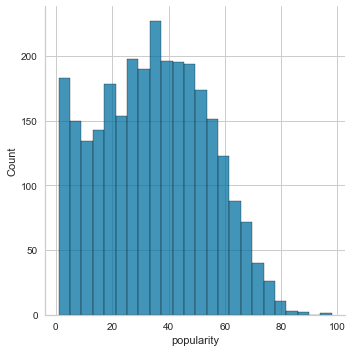

In [10]:
sns.displot(df['popularity'])

### Correlation Heatmap

Creating a heatmap to get an overview of the dataset correlations.

__Some observations__


*   Track energy and track dance are correlating.
*   Track energy correlates with other tracks on the same album, indicating that within an album tracks seem to have the same energy levels.
*   Looking at the columns correlation with popularity, we can see that there are no heavy correlations except ID?
* We looked at the dataset of which this is a subset and noticed that the popularity correlations in the large dataset were higher. Assuming our subsample is representative of the larger dataset we can also assume that our dataset is too small to show any real correlations. This might be bad news for our hypothesis of training models which predict better than random.

Many of the features are correlating, which might negatively impact some models. Performing PCA on the dataset might mitigate this problem.




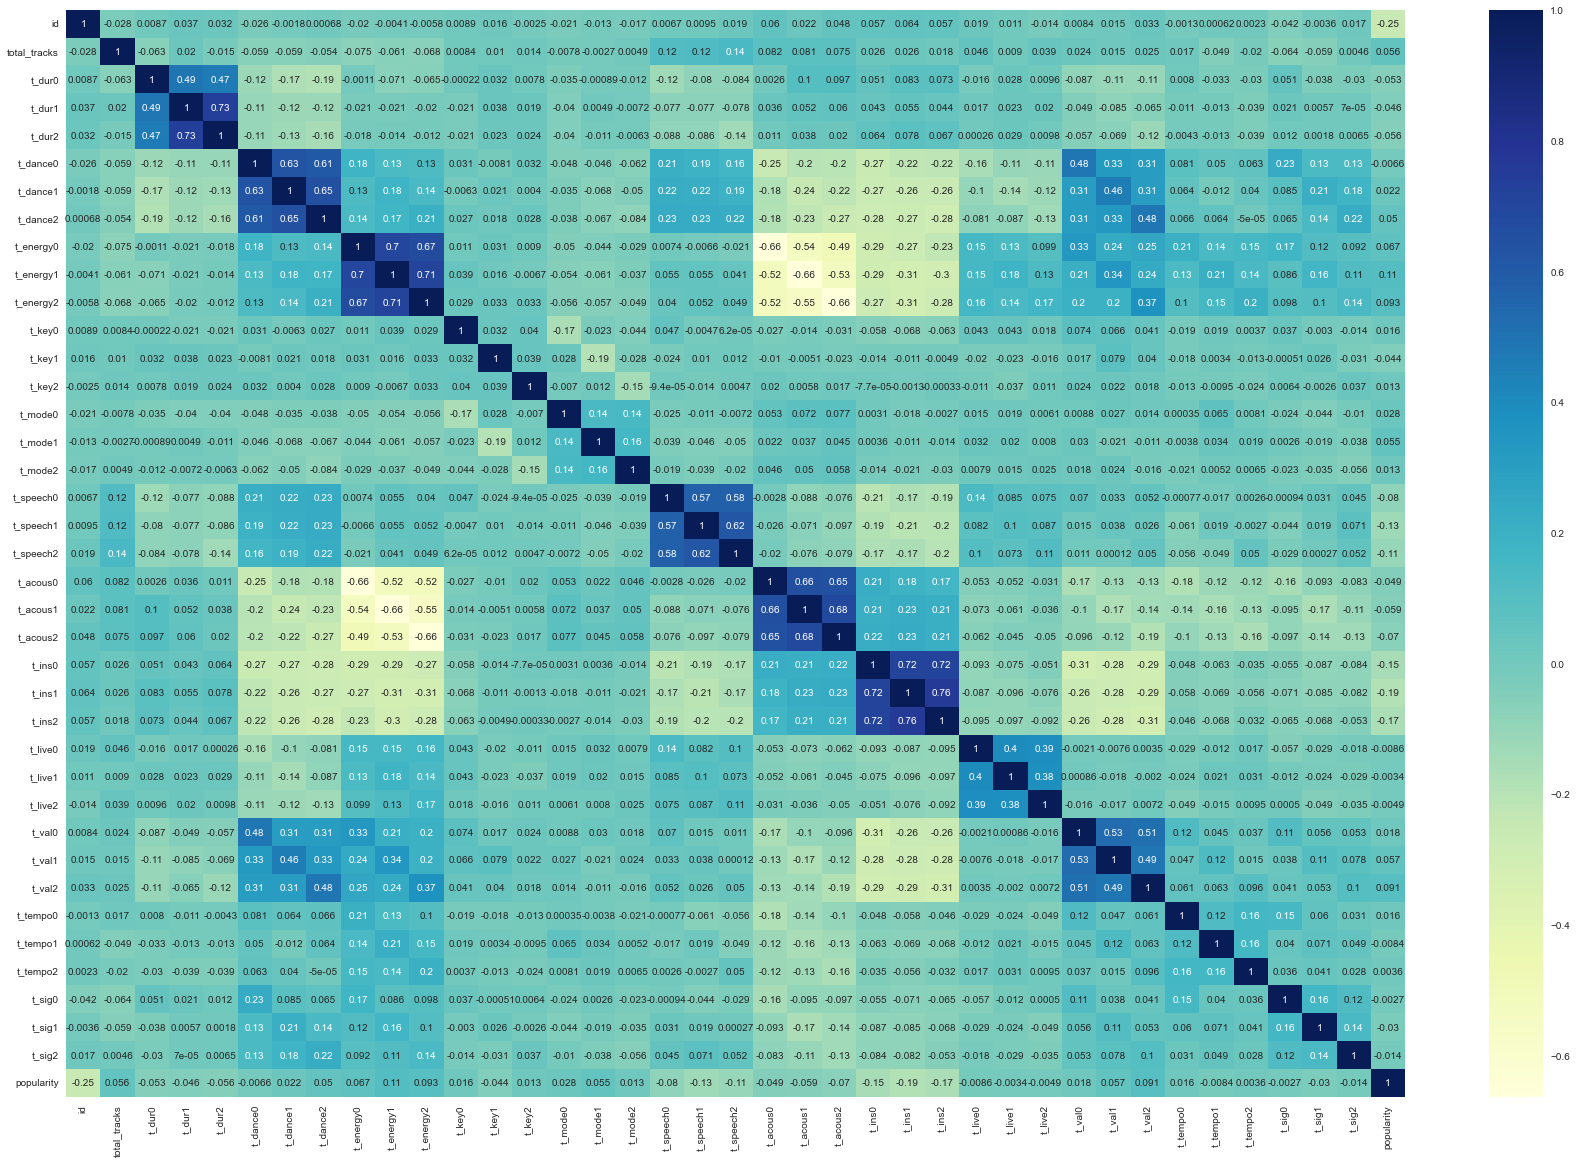

In [11]:
plt.figure(figsize=(30, 20))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [12]:
df[['id']].describe()

,id
count,2833.000000
mean,69686.243558
std,47651.496611
min,1.000000
25%,26176.000000
50%,65859.000000
75%,109766.000000
max,159971.000000


### Why does ID have the highest correlation?
In the original dataset ID has a very low correlation. Why is it larger in ours? We see in the heatmap that ID has a high negative correlation with popularity. As we can't find any reason for ID having a significant correlation with popularity, other than anomalies in the data set, we won't use it for training and testing the models. 

### Artist info
92% of the albums have unique artists appearing, only 8% of albums have reappearing artists from another row in the dataset. Could we use this to predict popularity?

In [13]:
# Amount of unique artists
artists = []
for artists_row in df['artists']:
  artists_row_split = artists_row.split(", ")
  for artist in artists_row_split:
    if artist != '':
      artists.append(artist)
artists = pd.DataFrame(artists)

unique_artists= len(artists[0].unique())
repeated_appearances = artists.shape[0]-len(artists[0].unique())
print(f"Number of single artists appearances: {artists.shape[0]} vs. Amount of rows: {df.shape[0]}")
print(f"Number of unique single artists: {unique_artists}")
print(f"Number of times an artist appears in multiple albums:{repeated_appearances}. Percentage: {df.shape[0]/repeated_appearances}")

Number of single artists appearances: 3198 vs. Amount of rows: 2833
Number of unique single artists: 2847
Number of times an artist appears in multiple albums:351. Percentage: 8.07122507122507


### Most popular albums
Lets check which albums are the most popular ones in the dataset.

Looking at the top albums in the dataset we can see that most of the more popular albums are released recently. We'll come back to this later.

In [14]:
df.sort_values(by=['popularity'], ascending=False).head()

,name,id,release_date,artists,total_tracks,t_name0,t_name1,t_name2,t_dur0,t_dur1,t_dur2,t_dance0,t_dance1,t_dance2,t_energy0,t_energy1,t_energy2,t_key0,t_key1,t_key2,t_mode0,t_mode1,t_mode2,t_speech0,t_speech1,t_speech2,t_acous0,t_acous1,t_acous2,t_ins0,t_ins1,t_ins2,t_live0,t_live1,t_live2,t_val0,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity
583,Donda,1013,2021-08-29,"Kanye West,",27,Donda Chant,Jail,God Breathed,52061,297000.0,333461.0,0.702,0.458,0.325,0.0474,0.571,0.311,3.0,4.0,10.0,0.0,1.0,1.0,0.5260,0.0949,0.0442,0.00516,0.5350,0.2890,0.000001,0.000305,0.000067,0.147,0.0846,0.1100,0.175,0.586,0.0789,102.983,110.013,92.744,4.0,4.0,3.0,98
967,Hollywood's Bleeding,36,2019-09-06,"Post Malone,",17,Hollywood's Bleeding,Saint-Tropez,Enemies (feat. DaBaby),156266,150866.0,196760.0,0.405,0.617,0.542,0.6460,0.684,0.674,4.0,0.0,6.0,0.0,1.0,1.0,0.0476,0.0439,0.2100,0.33100,0.0545,0.0588,0.000000,0.000000,0.000000,0.103,0.1040,0.0955,0.170,0.295,0.6670,130.218,132.113,76.388,4.0,4.0,4.0,86
1376,MONTERO (Call Me By Your Name),4547,2021-03-31,"Lil Nas X,",3,MONTERO (Call Me By Your Name),MONTERO (Call Me By Your Name) - SATAN'S EXTEN...,MONTERO (Call Me By Your Name) - But Lil Nas X...,137875,170054.0,168031.0,0.610,0.511,0.820,0.5080,0.540,0.545,8.0,8.0,8.0,0.0,0.0,0.0,0.1520,0.1740,0.6680,0.29700,0.1910,0.1680,0.000000,0.000000,0.886000,0.384,0.3770,0.3440,0.758,0.711,0.1400,178.818,119.248,178.997,4.0,5.0,4.0,86
1111,JORDI (Deluxe),5593,2021-06-11,"Maroon 5,",14,Beautiful Mistakes (feat. Megan Thee Stallion),Lost,Echo (feat. blackbear),227395,172597.0,178620.0,0.713,0.766,0.759,0.6760,0.706,0.670,10.0,7.0,1.0,1.0,0.0,1.0,0.0270,0.1600,0.0509,0.03770,0.2230,0.0204,0.000000,0.000280,0.000000,0.154,0.0640,0.0953,0.721,0.766,0.7410,99.048,142.989,136.027,4.0,4.0,4.0,83
1365,MAP OF THE SOUL : 7,1257,2020-02-21,"BTS,",20,Intro : Persona,Boy With Luv (Feat. Halsey),Make It Right,171023,229773.0,226321.0,0.469,0.645,0.638,0.8700,0.862,0.703,9.0,11.0,7.0,0.0,0.0,1.0,0.3420,0.0965,0.4440,0.02780,0.0923,0.0104,0.000000,0.000000,0.000000,0.313,0.1920,0.1320,0.652,0.798,0.2610,86.622,119.991,105.766,4.0,4.0,4.0,82


### What would our error metric be if the model just predicted mean?
This can be compared with model metric to get an intuition of how well it is doing. Is our model better than just guessing the mean?

In [15]:
def mean_mae(column):
    """
    Calculates what the mean absolute error of guessing the mean on column col_name would be.
    :param: df: Pandas dataframe
    :param: col_name: Name of numerical column in df
    :return: mae of always predicting mean
    """
    mean = column.mean()
    mean_pred = [mean]*len(column)
    mae = mean_absolute_error(mean_pred, column)
    return mae
        
def mean_mse(column):
    """
    Calculates what the mean squared error of guessing the mean on column col_name would be.
    :param: df: Pandas dataframe
    :param: col_name: Name of numerical column in df
    :return: mae of always predicting mean
    """
    mean = column.mean()
    mean_pred = [mean]*len(column)
    mae = mean_squared_error(mean_pred, column)
    return mae

These are the mean squared errors and mean absolute errors our models should score higher than:

In [16]:
print(f"MAE: {mean_mae(df['popularity'])}, MSE: {mean_mse(df['popularity'])}")

MAE: 15.845508204760868, MSE: 360.22962266236175


## Data cleaning / Enriching

### Artist ID
As we saw earlier, some artists reappear on multiple albums. Could we represent this in some way? Maybe the model can learn how they affect different albums popularities? 

__Proposal__:
Assigning ID's to all artists and duplicate album rows for each contributing artist.

__Pros__: 
* We get a usable representation of how artists contribute to albums

__Cons__: 
* Numeric ID will be interpreted as a continouous variable and not categorically as intended
* Albums with many artists will be overrepresented in the dataset

__Conclusion:__
To treat artists as a category we would have to one-hot encode them. This would create new dimensions from 92% of our rows, which would be a huge increase in dimensions with an unproportionately low information gain. This is probably not worth the possible score increase from representing the 8% of artists reappering in different albums.

### Creating keyword column
Adding binary columns if tracks contain certain keywords or not.

In [17]:
keywords = ['Remix', 'Instrumental', 'Edit', 'Feat.', 'Intro', 'Soundtrack', 'Live', 'Remaster']
def keyWordColumn(keywords):
    for keyword in keywords:
        df["contains_" + keyword] = (df['t_name0']+df['t_name1']+df['t_name2']).map(lambda x: 1 if keyword in x else 0)
keyWordColumn(keywords)

### Converting release_date to years

Converting release date from dd/mm/yyyy to yyyy, making it a continouous variable.

In [18]:
def dt_to_years(df):
  years = []
  for rd in df['release_date']:
    years.append(int(rd.split('-')[0]))
  df['release_date'] = years

In [19]:
dt_to_years(df)

### Detecting album language
Understanding the language of an albums lyrics is probably quite important to the albums popularity. 

As discussed with Bjørnar, we've used an IBM NLP API to detect languages in our string columns, and will provide a .csv with the data instead giving away personal API credentials. Code for integrating the .csv in the dataframe is provided below and will run if the .csv is located at root level together with albums_all.csv.

The code used to generate the .csv from the API is also provided below.

IBM Cloud NLP Services

In [20]:
def get_translator(api_key, url):
  """
  Call IBM Cloud API to authenticate and generate a translator object
  :param: api_key: IBM Cloud NLP instance API key
  :param: url: IBM cloud NLP instance URL
  :return: Language Translator object
  """
  authenticator = IAMAuthenticator(api_key)
  language_translator = LanguageTranslatorV3(
      version='2022-04-01',
      authenticator=authenticator
      )
  language_translator.set_service_url(url)
  return language_translator


def get_language(string, language_translator):
  """
  Function for detecting language in string, handling API exceptions.
  :param: string: Sentence to detect language from.
  :param: language_translator: Translator object
  :return: tuple with language abbreviation and confidence level deducted from string
  """
  #parameters = {"text":string}
  try:
    response = language_translator.identify(
        string,
        #headers = {
        #    "Content-Type": "application/json"
        #    }
        )
    # Extract language code with highest confidence level
    results = response.result["languages"][0]
    language = results["language"]
    confidence = results["confidence"]
    return (language, confidence)
  except ApiException as ex:
    print("Method failed with status code " + str(ex.code) + ": " + ex.message)
    return (float("NaN"), float("NaN"))


def generate_language_df(words, language_translator, to_file = True):
  """
  Use dataframe column of words to generate dataframe of language approximated by IBM Watson NLP.
  :param: words: Pandas Dataframe object with sentences to analyze.
  :param: language_translator: Language translator object
  :param: to_file (default:True): Whether to generate .csv file or not.
  :return: Indexed Dataframe with two columns: Words and estimated language
  """  
  detection = pd.DataFrame(columns = ["words", "language", "confidence"])
  for i in range(len(words)):
    curr_words = words[i]
    detection.loc[i, "words"] = curr_words
    nlp_results = get_language(curr_words, language_translator)
    language = nlp_results[0]
    confidence = nlp_results[1]
    detection.loc[i, "language"] = language
    detection.loc[i, "confidence"] = confidence
  
  if to_file:
    detection.to_csv("languages.csv")

  return detection

### Use IBM NLP API to deduce language from words
This function will either use root level languages.csv or ask for API credentials to generate new one.

In [21]:
# Load or generate language dataframe
def get_languages():
  if not os.path.isfile('languages.csv'):
    print("No language.csv file detected.")
    re_generate = input(f"""
    If you have a file, put it it in {os.getcwd()} and press enter.
    Otherwise, write 're-generate', press enter and provide API-key and URL from IBM cloud.
    """)
    if re_generate == "re-generate":
      api_key = input("Please provide API-key")
      url = input("Please provide URL")
      language_translator = get_translator("API-key", "URL")
      
      # Quick tests
      print(get_language("Hei dette er norsk", language_translator), "Should be 'no'")
      print(get_language("This is an quite erroneous text", language_translator), "Should be 'en'")
      print(get_language('du hast mich gefragt und ich hab nichts gesagt', language_translator), "Should be 'de")

      # Pack relevant string columns into one for language prediction
      combined = pd.DataFrame()
      combined['words'] = df[['name','t_name0','t_name1','t_name2']].agg(" ".join, axis=1)

      # Generate DF and upload it to cwd as 'languages.csv'
      generate_language_df(combined['words'], language_translator)
    
    # Try loading the file again
    return get_languages()
      
  else:
    return pd.read_csv("languages.csv")

languages = get_languages()

### Integrate language.csv into df as column indicating english or not


Mean language confidence level is 89%. This might be good enough to improve our model.

In [22]:
sum(languages['confidence'])/len(languages)

0.8893329056425198

Merge language column with rest of df

In [23]:
df["language"] = languages['language']

Comparing language appearances

{'en': 1912, 'de': 54, 'nl': 36, 'sv': 19, 'pl': 28, 'it': 52, 'fr': 45, 'es': 235, 'eu': 10, 'pt': 48, 'so': 39, 'ar': 3, 'fi': 26, 'nn': 34, 'tl': 27, 'ms': 31, 'ro': 6, 'hr': 23, 'et': 13, 'tr': 38, 'eo': 4, 'sq': 13, 'mt': 2, 'cy': 8, 'zh-TW': 15, 'ht': 5, 'fa': 1, 'ko': 2, 'is': 2, 'af': 5, 'hu': 6, 'ku': 6, 'nb': 6, 'ga': 2, 'lt': 6, 'az': 5, 'cs': 4, 'sk': 4, 'vi': 9, 'th': 1, 'da': 8, 'sl': 3, 'ru': 19, 'ja': 11, 'ca': 1, 'lv': 1, 'bg': 1, 'he': 3, 'zh': 1}
{'fa': 1, 'th': 1, 'ca': 1, 'lv': 1, 'bg': 1, 'zh': 1, 'mt': 2, 'ko': 2, 'is': 2, 'ga': 2, 'ar': 3, 'sl': 3, 'he': 3, 'eo': 4, 'cs': 4, 'sk': 4, 'ht': 5, 'af': 5, 'az': 5, 'ro': 6, 'hu': 6, 'ku': 6, 'nb': 6, 'lt': 6, 'cy': 8, 'da': 8, 'vi': 9, 'eu': 10, 'ja': 11, 'et': 13, 'sq': 13, 'zh-TW': 15, 'sv': 19, 'ru': 19, 'hr': 23, 'fi': 26, 'tl': 27, 'pl': 28, 'ms': 31, 'nn': 34, 'nl': 36, 'tr': 38, 'so': 39, 'fr': 45, 'pt': 48, 'it': 52, 'de': 54, 'es': 235, 'en': 1912}


<BarContainer object of 49 artists>

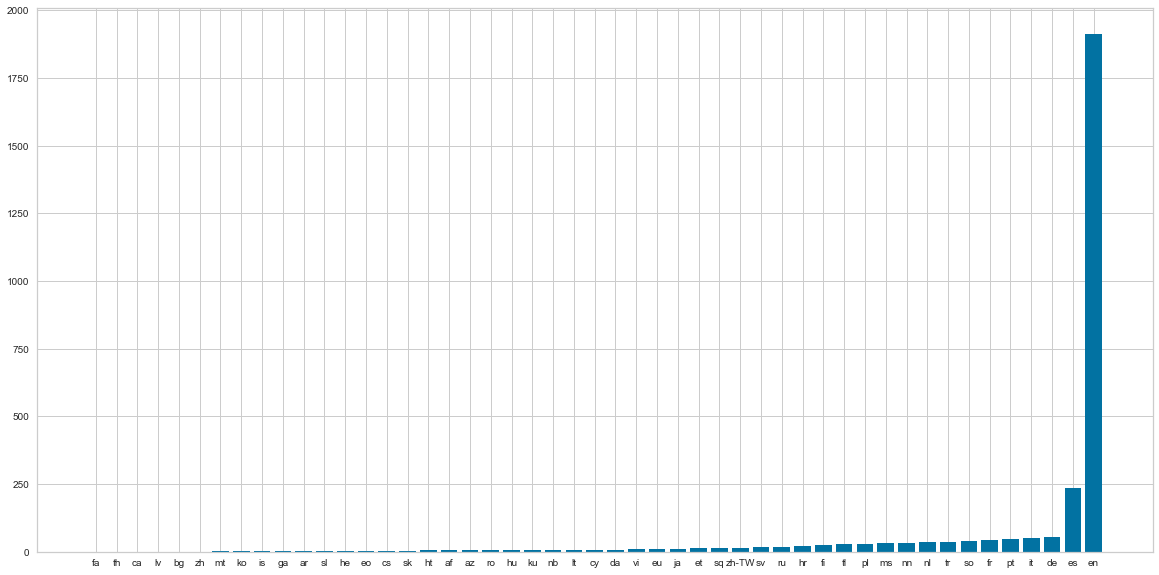

In [24]:

lang = pd.read_csv('languages.csv')
len(set(lang['language']))
d = dict()
for language in lang.language:
    d[language] = d.get(language,0) +1
print(d)
d = dict(sorted(d.items(), key=lambda item: item[1]))
print(d)
plt.figure(figsize=(20,10))

plt.bar(d.keys(),d.values())

In [25]:
df[['artists','name','t_name0', 't_name1', 't_name2', 'language', 'popularity']].sort_values(by=['popularity'], ascending=False).head(10)

,artists,name,t_name0,t_name1,t_name2,language,popularity
583,"Kanye West,",Donda,Donda Chant,Jail,God Breathed,en,98
967,"Post Malone,",Hollywood's Bleeding,Hollywood's Bleeding,Saint-Tropez,Enemies (feat. DaBaby),af,86
1376,"Lil Nas X,",MONTERO (Call Me By Your Name),MONTERO (Call Me By Your Name),MONTERO (Call Me By Your Name) - SATAN'S EXTEN...,MONTERO (Call Me By Your Name) - But Lil Nas X...,en,86
1111,"Maroon 5,",JORDI (Deluxe),Beautiful Mistakes (feat. Megan Thee Stallion),Lost,Echo (feat. blackbear),en,83
1365,"BTS,",MAP OF THE SOUL : 7,Intro : Persona,Boy With Luv (Feat. Halsey),Make It Right,en,82
724,"The Kid LAROI,",F*CK LOVE (SAVAGE),PIKACHU,SO DONE,TRAGIC (feat. Youngboy Never Broke Again & Int...,en,82
585,"Bruno Mars,",Doo-Wops & Hooligans,Grenade,Just the Way You Are,Our First Time,en,81
1038,"Halsey,","If I Can’t Have Love, I Want Power",The Tradition,Bells in Santa Fe,Easier than Lying,en,81
931,"Harry Styles,",Harry Styles,Meet Me in the Hallway,Sign of the Times,Carolina,en,80
2602,"Bad Bunny,",X 100PRE,NI BIEN NI MAL,200 Mph,¿Quien Tu Eres?,es,80


__Sorting the dataset descending by popularity:__
A quick look tells us that the 10 most popular albums are almost all in english. The confidence level also corresponds with this subset, as Post Malone's album is supposed to be classified as english, not african, but the rest of the rows are correctly classified. Because most of the popular songs are english, we can assume that this correlates with popularity. Representing all languages as categories in the dataset will create too many dimensions, so we choose the two decisively largest: english and spanish. We can represent these by creating binary columns indicating 1 for "x language detected" and 0 for "x language not detected".


Creating the binary columns

In [26]:
def create_lang_col(df, lang, iso_name):
    new_col = []
    for iso in df.language:
        if iso == iso_name:
            new_col.append(1)
        else:
            new_col.append(0)
    df[lang] = new_col
    
create_lang_col(df, "english", "en")
create_lang_col(df, "spanish", "es")


In [27]:
df

,name,id,release_date,artists,total_tracks,t_name0,t_name1,t_name2,t_dur0,t_dur1,t_dur2,t_dance0,t_dance1,t_dance2,t_energy0,t_energy1,t_energy2,t_key0,t_key1,t_key2,t_mode0,t_mode1,t_mode2,t_speech0,t_speech1,t_speech2,t_acous0,t_acous1,t_acous2,t_ins0,t_ins1,t_ins2,t_live0,t_live1,t_live2,t_val0,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity,contains_Remix,contains_Instrumental,contains_Edit,contains_Feat.,contains_Intro,contains_Soundtrack,contains_Live,contains_Remaster,language,english,spanish
0,"""Fragtime"" Theme Song ""Fragile""",22352,2000,"Moritani Misuzu (CV:Miku Ito), Murakami Haruka...",4,Fragile,11:00a.m.,Fragile - Instrumental,292720,293760.0,292733.0,0.549,0.623,0.5190,0.559,0.256,0.463,2.0,11.0,2.0,0.0,1.0,0.0,0.0256,0.0380,0.0253,0.5690,0.863000,0.077400,0.000000,0.000080,0.792000,0.0503,0.1100,0.0458,0.3300,0.5390,0.1920,84.008,187.910,84.002,4.0,3.0,4.0,21,0,1,0,0,0,0,0,0,en,1,0
1,"""Green n' gold Hits""",106534,2011,"C.W.A. Cheeseheads With Attitude,",12,"""Packer Face"" (Everybody Vince Lombardi)","""I Love Green Bay"" (Player Mix)","""Beer Wit Da Bret""",213760,181000.0,245973.0,0.871,0.702,0.4160,0.854,0.893,0.889,4.0,11.0,9.0,1.0,0.0,1.0,0.0420,0.0435,0.2760,0.0479,0.078600,0.004880,0.000011,0.000225,0.000000,0.0819,0.0687,0.1070,0.9650,0.7830,0.3770,119.032,128.002,181.241,4.0,4.0,4.0,14,0,0,0,0,0,0,0,0,en,1,0
2,"""Zuhause Live: Das Laune der Natour-Finale"" pl...",23608,2019,"Die Toten Hosen,",59,Laune der Natur - das Intro - Live in Düsseldo...,Opel-Gang - Live in Düsseldorf 2018,Auswärtsspiel - Live in Düsseldorf 2018,157124,130446.0,152450.0,0.289,0.328,0.2340,0.936,0.995,0.997,10.0,11.0,6.0,0.0,1.0,0.0,0.0845,0.1480,0.1280,0.2710,0.000204,0.000195,0.047100,0.000000,0.008280,0.8410,0.9590,0.5940,0.5790,0.0475,0.0945,84.010,127.755,99.284,4.0,4.0,4.0,41,0,0,0,0,1,0,1,0,de,0,0
3,#Gsnls,8655,2020,"Surf'n,",8,Lock'n Legs,Capt'n Saven Em,Bloods & Crips,127896,176351.0,166968.0,0.886,0.947,0.8260,0.818,0.629,0.694,7.0,8.0,11.0,1.0,1.0,1.0,0.0928,0.1890,0.2710,0.1050,0.386000,0.076700,0.000000,0.000000,0.000000,0.1800,0.1520,0.6880,0.6240,0.3840,0.6510,100.053,99.999,95.017,4.0,4.0,4.0,1,0,0,0,0,0,0,0,0,nl,0,0
4,#Hektarparty,49670,2018,"Die Draufgänger,",17,Die Hektar hat 2.0,Johnny Deere,Gina Lisa (Spiel mit deinen Glocken),210320,226253.0,211880.0,0.724,0.791,0.7840,0.827,0.737,0.921,5.0,5.0,5.0,1.0,0.0,0.0,0.0283,0.1090,0.0445,0.0239,0.182000,0.092900,0.000000,0.000000,0.000008,0.1560,0.0592,0.1490,0.8400,0.6650,0.5200,128.041,132.013,135.969,4.0,4.0,4.0,47,0,0,0,0,0,0,0,0,de,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,邱振哲<遠行的太陽>首張創作專輯,33980,2018,"Pika Chiu,",10,遠行(intro),太陽,兩分鐘,70740,262400.0,220680.0,0.224,0.609,0.7110,0.348,0.595,0.730,8.0,3.0,11.0,1.0,1.0,0.0,0.0494,0.0325,0.0459,0.4600,0.327000,0.340000,0.844000,0.000000,0.000000,0.1470,0.1270,0.1060,0.0931,0.2270,0.5140,68.712,124.081,129.056,3.0,4.0,4.0,47,0,0,0,0,0,0,0,0,zh-TW,0,0
2829,韋禮安首張同名全創作專輯,110832,2010,"WeiBird,",10,有沒有,兩腳書櫥的逃亡,故事,252226,222400.0,214973.0,0.526,0.623,0.4820,0.293,0.689,0.669,7.0,2.0,2.0,1.0,1.0,1.0,0.0293,0.0307,0.0295,0.1720,0.113000,0.146000,0.000000,0.000000,0.000000,0.2330,0.1100,0.0661,0.2130,0.4020,0.5590,113.940,93.018,96.983,3.0,4.0,4.0,40,0,0,0,0,0,0,0,0,zh-TW,0,0
2830,魔杰座,14491,2008,"Jay Chou,",11,龍戰騎士,給我一首歌的時間,蛇 舞,269146,251560.0,172760.0,0.551,0.756,0.7820,0.901,0.635,0.779,2.0,1.0,9.0,0.0,1.0,1.0,0.0731,0.0282,0.0431,0.0189,0.272000,0.120000,0.038100,0.000000,0.030100,0.1070,0.1460,0.0867,0.3240,0.5190,0.6730,115.978,118.004,107.972,4.0,4.0,4.0,55,0,0,0,0,0,0,0,0,zh-TW,0,0
2831,신비체험,123511,2003,"Lee Sang-Eun,",13,Soulmate,The World Is An Orchestra,비밀의 화원,344764,425613.0,249652.0,0.473,0.572,0.8230,0.146,0.219,0.541,9.0,8.0,6.0,0.0,1.0,1.0,0.0301,0.0558,0.0333,0.9180,0.963000,0.687000,0.00006

### Add column indicating special characters in name
Maybe cool song names contribute to album popularity.

In [28]:
# Create new column with 1 for containing special characters
normal_characters = string.ascii_lowercase + string.ascii_uppercase + "1234567890" + "-" + '"' + " "
df['special_character_name'] = df['name'].map(lambda x: 1 if any([True for letter in x if not (letter in normal_characters)]) else 0)
#df

In [29]:
df.columns

Index(['name', 'id', 'release_date', 'artists', 'total_tracks', 't_name0',
       't_name1', 't_name2', 't_dur0', 't_dur1', 't_dur2', 't_dance0',
       't_dance1', 't_dance2', 't_energy0', 't_energy1', 't_energy2', 't_key0',
       't_key1', 't_key2', 't_mode0', 't_mode1', 't_mode2', 't_speech0',
       't_speech1', 't_speech2', 't_acous0', 't_acous1', 't_acous2', 't_ins0',
       't_ins1', 't_ins2', 't_live0', 't_live1', 't_live2', 't_val0', 't_val1',
       't_val2', 't_tempo0', 't_tempo1', 't_tempo2', 't_sig0', 't_sig1',
       't_sig2', 'popularity', 'contains_Remix', 'contains_Instrumental',
       'contains_Edit', 'contains_Feat.', 'contains_Intro',
       'contains_Soundtrack', 'contains_Live', 'contains_Remaster', 'language',
       'english', 'spanish', 'special_character_name'],
      dtype='object')

## TrainTest Split
Dropping string columns.

In [30]:
X = df.drop(['id','popularity', 't_name0','t_name1','t_name2','artists','name', 'language'], axis=1)
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69)

## Scoring Methods:
__MSE__: Mean squared error
<br>
__R2 score__: R^2 is a measure of the goodness of fit of a model. In regression, the R^2 coefficient of determination 
is a statistical measure of how well the regression predictions approximate the real data points
<br>
__MAE__: Mean absolute error

__Goal__: MSE under 360.22 and MAE under 15.8455. These were the values we calculated earlier using the mean_mse() and mean_mae() functions on the popularity feature. These are the MAE and MSE scores you would get if you guessed the mean for each target feature.

## Visualization functions

In [31]:

def prediction_dist(X_test, y_test, model):
    # Sort test data on popularity
    test_data = X_test.join(y_test)
    sorted_data = test_data.sort_values("popularity")

    # Sort data for plotting
    sorted_y_test = sorted_data['popularity']
    sorted_X_test = sorted_data.drop("popularity", axis=1)
    sorted_pred = model.predict(sorted_X_test)

    # Plot predicted popularity distribution on test set
    fig, ax = plt.subplots()
    sns.histplot(sorted_pred, ax=ax).set(title='Predicted distribution')
    ax.set_xlim(0,100)
    ax.set_ylim(0,110)
    ax.set_xticks(range(0,100,10))
    plt.xlabel='popularity'
    plt.show()

    # Plot actual popularity distribution in test set
    fig, ax = plt.subplots()
    sns.histplot(sorted_y_test, ax=ax).set(title='Actual distribution')
    ax.set_xlim(0,100)
    ax.set_ylim(0,110)
    ax.set_xticks(range(0,100,10))
    plt.show()

def feature_imp(X_train, model):
    # Feature importance dataframe
    imp_df = pd.DataFrame({'feature': X_train.columns.values,
                           'importance': model.feature_importances_})
    
    # Reorder by importance
    ordered_df = imp_df.sort_values(by='importance')
    imp_range=range(1,len(imp_df.index)+1)
    
    ## Barplot with confidence intervals
    height = ordered_df.tail(20)['importance']
    bars = ordered_df.tail(20)['feature']
    y_pos = np.arange(len(bars))

    # Create horizontal bars
    plt.barh(y_pos, height)
 
    # Create names on the y-axis
    plt.yticks(y_pos, bars)

    plt.tight_layout()
    plt.figure(figsize=(30, 20))

In [32]:
def task_a_results(model, X_train, y_train, X_test, y_test):
    X_train_pred = model.predict(X_train)
    X_test_pred = model.predict(X_test)
    end = time.time()

    fit_time = end - start

    print("Fit time:", fit_time, "seconds")
    print("================================")
    print()
    print("MSE: ", mean_squared_error(y_test,X_test_pred))
    print("r2 train score: ", r2_score(y_train,X_train_pred))
    print("r2 test score: ", r2_score(y_test,X_test_pred))
    print("MAE: ", mean_absolute_error(y_test,X_test_pred))

## Model 1 : DecisionTree
### Why this model:
Pros:
* No normalisation / regularization needed.
* Requires little data preprocessing: no need for one-hot encoding, dummy variables, and so on.
* Feature selection happens automatically: unimportant features will not influence the result.
* We don't have too many features.
* Not sensitive to outliers.

Cons:
* Sensitive to 0-values. Our binary language columns might have a negative impact here.
* Tends to overfit.

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)

start = time.time()
tree.fit(X_train, y_train)

task_a_results(tree, X_train, y_train, X_test, y_test)

Fit time: 0.0728003978729248 seconds

MSE:  649.4401408450705
r2 train score:  1.0
r2 test score:  -0.7626843207299909
MAE:  20.33450704225352


__DecisionTree Summary__:

Goal MAE: 15.8455
Model MAE:  20.33

Goal MSE: 360
Model MSE: 649


The first model performed worse than the goal, our goal being if the model was just predicting mean. 
It also overfitted 100% to the data, seen on the r2 scores for training data and test data. As this is a quite simple model which does not handle small and complex data sets as our own well, we will try some other models instead of trying to mitigate this. Decision tree ensembles such as random forest, which is a meta estimator that fits  classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting, might work better.


## Model 2 : RandomForest
### Why this model:
Pros:
* No normalisation / regularization needed.
* Intuitive
* Lower risk of overfitting.
* Robust to outliers.

Cons:
* Computationally expensive to train.

Using decition trees are widely known for high accuracy, especially ensemble desicion trees like __Random Forest__, __Extra Trees__ and __Gradient Boosting__. Slow training should not be an issue because of our small dataset and access to computational power.


In [34]:
rf_regr = RandomForestRegressor()

start = time.time()
rf_regr.fit(X_train, y_train)

task_a_results(rf_regr, X_train, y_train, X_test, y_test)

Fit time: 3.5473825931549072 seconds

MSE:  292.2609320422535
r2 train score:  0.8857195910971131
r2 test score:  0.20675712806654112
MAE:  13.966021126760563


__Random Forest Summary:__

Goal MAE: 15.8455
Model MAE: 14.02
<br>
Goal MSE: 360
Model MSE: 295.66

Using random forest performed significantly better than the single decision tree with a MAE of 14.02 which is better than our goal. However, it still overfits a lot. Maybe a grid search can help us tune parameters to prevent this?


In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [10, 40, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None, 5, 10, 30],
    'min_samples_split' : [3,5,9]
}
start = time.time()
CV_rf_regr = GridSearchCV(estimator=rf_regr, param_grid=param_grid, cv=5)
CV_rf_regr.fit(X_train, y_train)

task_a_results(CV_rf_regr, X_train, y_train, X_test, y_test)

Fit time: 244.7190387248993 seconds

MSE:  295.75771033557453
r2 train score:  0.844448916266515
r2 test score:  0.1972663130043777
MAE:  14.023975713107314


__After Grid Search & Crossval:__
The new model is still overfit, and the training scores actually worsened slightly.

### Random forest visualizations

Popularity distribution

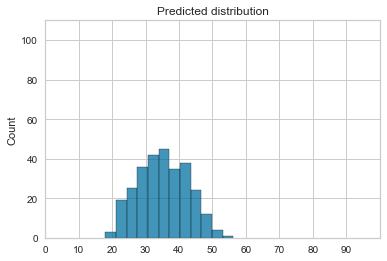

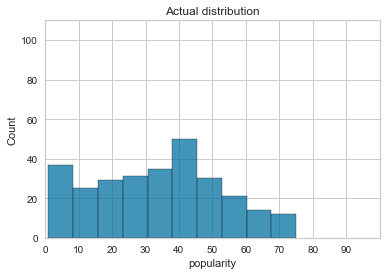

In [36]:
prediction_dist(X_test, y_test, CV_rf_regr)

In [37]:
# Feature importance based on the random forest model

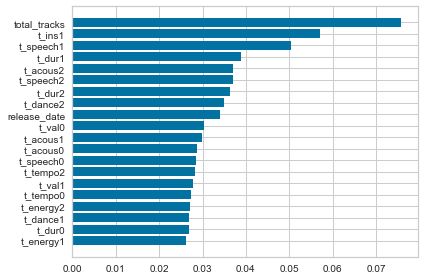

<Figure size 2160x1440 with 0 Axes>

In [38]:
feature_imp(X_train, rf_regr)

The model also misses some of the low popularity scores. Maybe a Gradient Boosting ensemble is better for our task?

## Model 3 : Gradient Boosting
Builds decision trees in another way than random forest. Will this have an impact on performance?

In [39]:
gbr = GradientBoostingRegressor(ccp_alpha=0.2, criterion='friedman_mse', learning_rate=0.15, max_depth=8,max_features='sqrt',
                          min_impurity_decrease=1.0, min_samples_leaf=5, min_samples_split=9, n_estimators=50,
                          random_state=2825, subsample=0.9)

start = time.time()
gbr.fit(X_train, y_train)

task_a_results(gbr, X_train, y_train, X_test, y_test)

Fit time: 0.26029133796691895 seconds

MSE:  287.5792520423742
r2 train score:  0.8062540370671198
r2 test score:  0.21946395570384158
MAE:  13.652265628100825


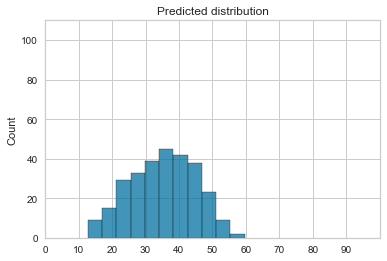

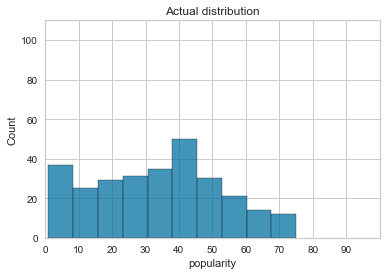

In [40]:
prediction_dist(X_test, y_test, gbr)

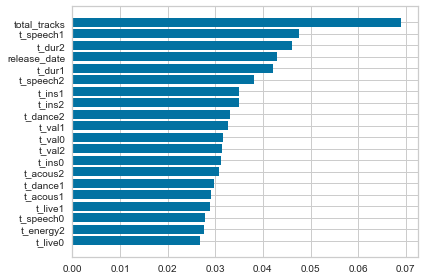

<Figure size 2160x1440 with 0 Axes>

In [41]:
feature_imp(X_train, gbr)

C:\Users\thoma\anaconda3\envs\ml_nvidia_gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


0.21946395570384158

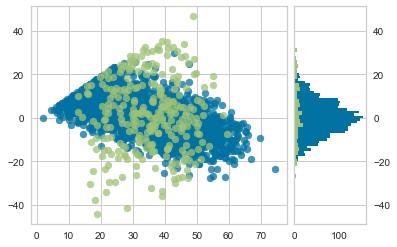

In [42]:
visualizer = ResidualsPlot(gbr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test) 

__Gradient Boosting Summary:__

Goal MAE: 15.8455
Model MAE: 13.65
Goal MSE: 360
Model MSE: 287.57

The model actually predicts better than the mean, but is still severely overfit. We could try to mitigate this by doing thourough gridsearching and parameter tuning, but we don't expect to achieve much better results. We'll save the time and processing power and move on to experiment on another type of model to see if it handles the data better.


# Models needing normal distribution

### One hot encoding
Now that we're done with the tree models we can process the data in ways that fit the other models better. We start with One Hot Encoding. 

In [43]:
# One hot encoding (not including these had no negative effect on random forest)
categorical = ['t_sig0', 't_sig1', 't_sig2', 't_key0','t_key1','t_key2', 't_mode0','t_mode1', 't_mode2']
df = pd.get_dummies(df, columns=categorical, drop_first=True)
print(df.shape)
df = df.reindex(sorted(df.columns), axis=1)

(2833, 96)


In [44]:
df.shape

(2833, 96)

### Removing outliers
Working towards approximate normal distribution without removing too many data points in the already sparse dataset.

We'll scale the data to fit the models better, but before we do this, we should remove the largest outliers so that the scale becomes right.

In [45]:
# Visualization code inspiration found on kaggle before generalization: https://www.kaggle.com/code/elemento/getting-started-visualization
def visualize_outliers(pd_series, title = None):
  if not title:
    title = pd_series.name
  plt.figure(figsize=(14, 10))
  plt.hist(pd_series, bins = 100)
  plt.locator_params(axis = "x", nbins = 24)
  plt.locator_params(axis = "y", nbins = 12)
  plt.title(f"Distribution of Albums according to the {pd_series.name}")
  plt.ylabel("Frequency")
  plt.grid()
  plt.show()

#### Popularity

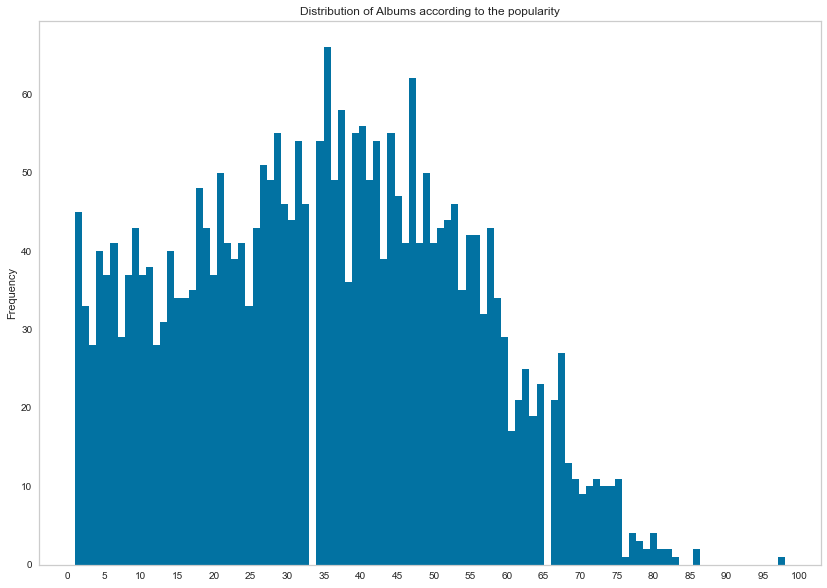

In [46]:
num_tracks = pd.Series(df['popularity'])

visualize_outliers(num_tracks)

The popularity data is a little bit skewed, but there are lots of data points in most places, and we want to be able to predict the whole scale of 0 - 100. The data is sparse, so we want to keep as much as possible. We can't realistically synthesize new popularity data, so we keep it as it is. 

#### Total tracks


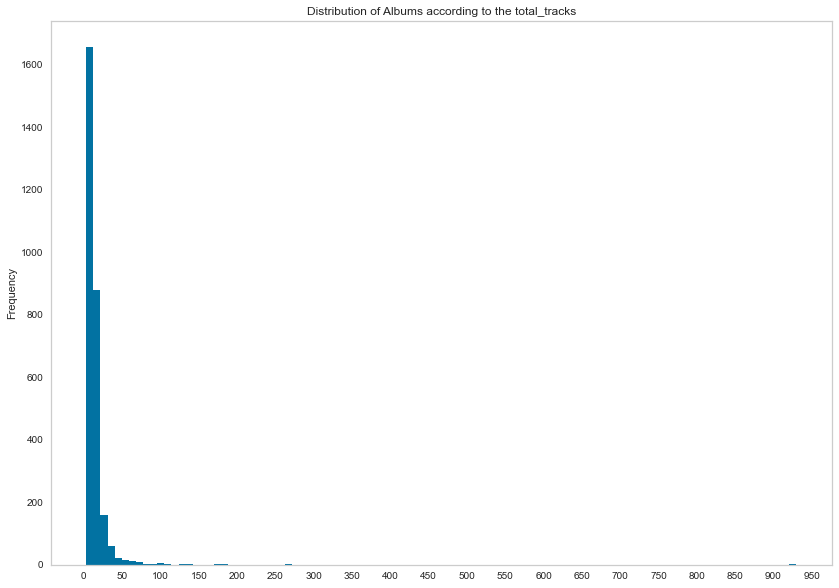

In [47]:
num_tracks = pd.Series(df['total_tracks'])

visualize_outliers(num_tracks)

This data set is hugely skewed! We estimate we can afford to lose all data exceeding 40 tracks without losing much data. Also, albums with more than 40 tracks are rare occurences, and they probably don't follow typical trends.

In [48]:
df = df.drop(df[df.total_tracks > 40].index)


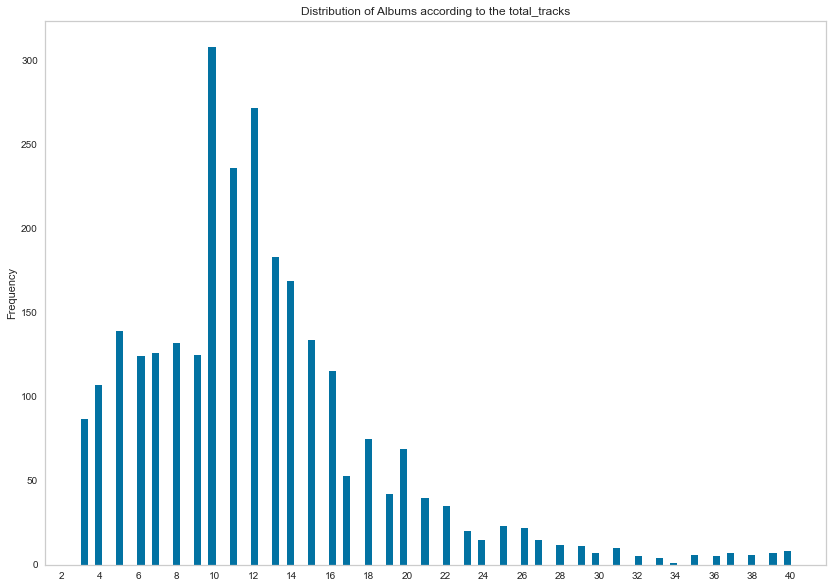

In [49]:
num_tracks = pd.Series(df['total_tracks'])

visualize_outliers(num_tracks)

#### Duration


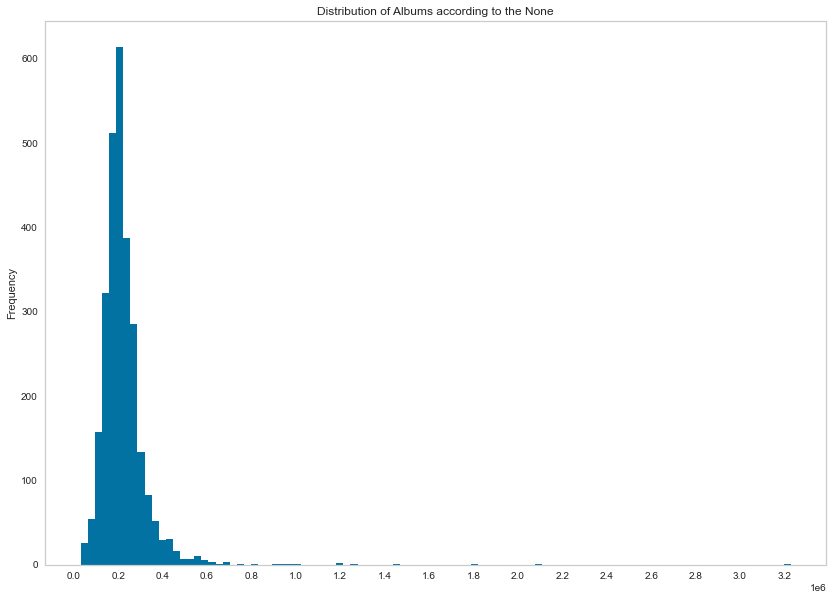

In [50]:
duration_means = pd.Series(df[["t_dur0", "t_dur1", "t_dur2"]].mean(axis=1))

visualize_outliers(duration_means, title = "Duration Means")

We'll remove the outliers over 600 000ms as to not lose too much data. Songs over 600 000ms are over 10 minutes long and there are very few of them,

In [51]:
df = df.drop(df[df.t_dur0 > 600000].index)
df = df.drop(df[df.t_dur1 > 600000].index)
df = df.drop(df[df.t_dur2 > 600000].index)


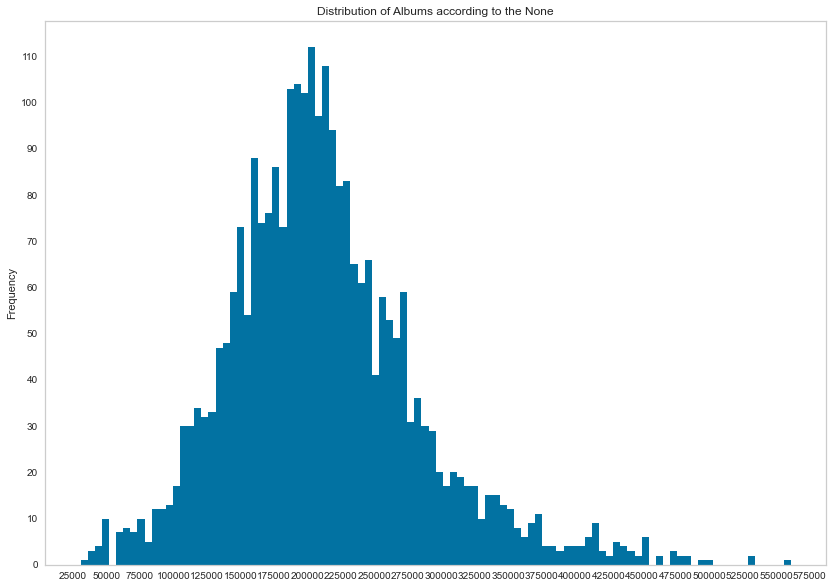

In [52]:
duration_means = pd.Series(df[["t_dur0", "t_dur1", "t_dur2"]].mean(axis=1))

visualize_outliers(duration_means, title = "Duration Means")

#### Release date
As albums have only existed a certain number of years, we don't expect any big outliers. However, we'll check the data for errors.

In [53]:
df[df.release_date > 2022]

,artists,contains_Edit,contains_Feat.,contains_Instrumental,contains_Intro,contains_Live,contains_Remaster,contains_Remix,contains_Soundtrack,english,id,language,name,popularity,release_date,spanish,special_character_name,t_acous0,t_acous1,t_acous2,t_dance0,t_dance1,t_dance2,t_dur0,t_dur1,t_dur2,t_energy0,t_energy1,t_energy2,t_ins0,t_ins1,t_ins2,t_key0_1.0,t_key0_10.0,t_key0_11.0,t_key0_2.0,t_key0_3.0,t_key0_4.0,t_key0_5.0,t_key0_6.0,t_key0_7.0,t_key0_8.0,t_key0_9.0,t_key1_1.0,t_key1_10.0,t_key1_11.0,t_key1_2.0,t_key1_3.0,t_key1_4.0,t_key1_5.0,t_key1_6.0,t_key1_7.0,t_key1_8.0,t_key1_9.0,t_key2_1.0,t_key2_10.0,t_key2_11.0,t_key2_2.0,t_key2_3.0,t_key2_4.0,t_key2_5.0,t_key2_6.0,t_key2_7.0,t_key2_8.0,t_key2_9.0,t_live0,t_live1,t_live2,t_mode0_1.0,t_mode1_1.0,t_mode2_1.0,t_name0,t_name1,t_name2,t_sig0_1.0,t_sig0_3.0,t_sig0_4.0,t_sig0_5.0,t_sig1_1.0,t_sig1_3.0,t_sig1_4.0,t_sig1_5.0,t_sig2_1.0,t_sig2_3.0,t_sig2_4.0,t_sig2_5.0,t_speech0,t_speech1,t_speech2,t_tempo0,t_tempo1,t_tempo2,t_val0,t_val1,t_val2,total_tracks


In [54]:
df[df.release_date < 1940]

,artists,contains_Edit,contains_Feat.,contains_Instrumental,contains_Intro,contains_Live,contains_Remaster,contains_Remix,contains_Soundtrack,english,id,language,name,popularity,release_date,spanish,special_character_name,t_acous0,t_acous1,t_acous2,t_dance0,t_dance1,t_dance2,t_dur0,t_dur1,t_dur2,t_energy0,t_energy1,t_energy2,t_ins0,t_ins1,t_ins2,t_key0_1.0,t_key0_10.0,t_key0_11.0,t_key0_2.0,t_key0_3.0,t_key0_4.0,t_key0_5.0,t_key0_6.0,t_key0_7.0,t_key0_8.0,t_key0_9.0,t_key1_1.0,t_key1_10.0,t_key1_11.0,t_key1_2.0,t_key1_3.0,t_key1_4.0,t_key1_5.0,t_key1_6.0,t_key1_7.0,t_key1_8.0,t_key1_9.0,t_key2_1.0,t_key2_10.0,t_key2_11.0,t_key2_2.0,t_key2_3.0,t_key2_4.0,t_key2_5.0,t_key2_6.0,t_key2_7.0,t_key2_8.0,t_key2_9.0,t_live0,t_live1,t_live2,t_mode0_1.0,t_mode1_1.0,t_mode2_1.0,t_name0,t_name1,t_name2,t_sig0_1.0,t_sig0_3.0,t_sig0_4.0,t_sig0_5.0,t_sig1_1.0,t_sig1_3.0,t_sig1_4.0,t_sig1_5.0,t_sig2_1.0,t_sig2_3.0,t_sig2_4.0,t_sig2_5.0,t_speech0,t_speech1,t_speech2,t_tempo0,t_tempo1,t_tempo2,t_val0,t_val1,t_val2,total_tracks


This album's release date is mislabeled! We remove it. 

In [55]:
df = df.drop(df[df.release_date < 1940].index)

#### Tempo

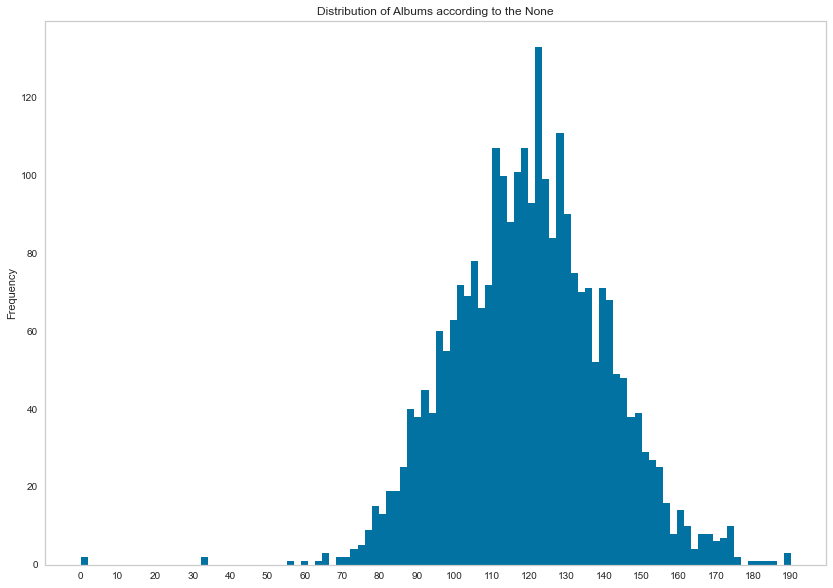

In [56]:
tempo_means = pd.Series(df[["t_tempo0", "t_tempo1", "t_tempo2"]].mean(axis=1))

visualize_outliers(tempo_means, title = "Tempo Means")


Tempo has very few but very far away outliers. Removing them...

In [57]:
df = df.drop(df[df.t_tempo0 < 40].index)
df = df.drop(df[df.t_tempo1 < 40].index)
df = df.drop(df[df.t_tempo2 < 40].index)


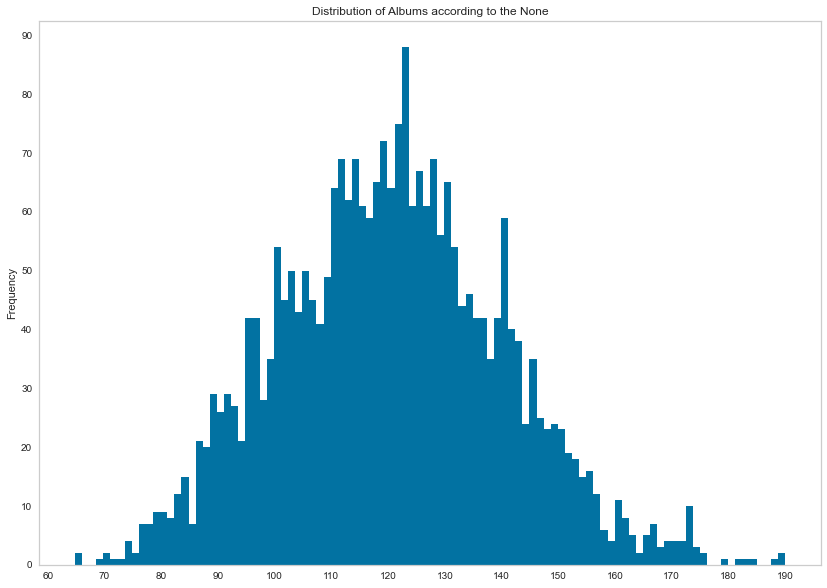

In [58]:
tempo_means = pd.Series(df[["t_tempo0", "t_tempo1", "t_tempo2"]].mean(axis=1))

visualize_outliers(tempo_means, title = "Tempo Means")

### Feature scaling
Some models need the features to be scaled differently. Underneath we create variants of the dataset for the different purposes.

In [59]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
continous_columns = ["release_date", "t_dur0", "t_dur1", "t_dur2", "total_tracks","t_tempo0", "t_tempo1", "t_tempo2"]
df[continous_columns] = min_max_scaler.fit_transform(df[continous_columns])

## Model 4: Linear regression 
### Why this model:
Pros: 
- easy to implement and interpert 
- Computionally efficient 

Cons:
- prone to noise and overfitting.
- sensetive to outliers
- assumes linear relationship between dependent and independent variables

Some of the cons are mitigated by removing outliers and scaling. The linear relationship assumption, on the other hand, might be problematic.

Dropping columns and splitting data again from the scaled dataframe.

In [60]:
#dropping coluumns that are not needed in linear regression 
X = df.drop(['id', 'popularity', 't_name0','t_name1','t_name2','artists','name','language'], axis=1)
y = df['popularity']

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=69)

Training the model

In [61]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

start = time.time()
linear_reg.fit(X_train, y_train)

task_a_results(linear_reg, X_train, y_train, X_test, y_test)

Fit time: 0.010000467300415039 seconds

MSE:  321.2764937557391
r2 train score:  0.16535488377210628
r2 test score:  0.10770167645380246
MAE:  14.811931553171641


__Basic Linear Regression Summary__:

Goal MAE: 15.8455
Model MAE:  14.71

Goal MSE: 360
Model MSE: 327

The low R2_score indicates we have a dataset which is non-linear.
Linear regression models tries to find a linear relationship between a dependent varibel (popularity in our case)
and one or more indepedent variabels (our features). Since our R2_score indicates a weak linear relationship,
between depedent and independent variabels, the linear regression model will have limited prediction power. 
In spite of that, the model did better than our tree models, and did not overfit.
To mitigate the effects of the non-linear dataset, we will impliment a binning function.
Binning the continouous variables will distribute the dataset into a number of bins, smoothing the data. Maybe this representation will enable the model to find a linear relationship after all?

In [62]:
#Binning all the features with are continious
continious_features = [ 't_acous0', 't_acous1','t_acous2', 
            't_dur0', 't_dur1', 't_dur2', 
            't_energy0', 't_energy1', 't_energy2',
            't_dance0', 't_dance1', 't_dance2',
            't_acous0', 't_acous1', 't_acous2',
            't_ins0', 't_ins1', 't_ins2', 
            't_live0', 't_live1', 't_live2',
            't_speech0', 't_speech1', 't_speech2',
            't_tempo0', 't_tempo1', 't_tempo2', 
            't_val0', 't_val1', 't_val2']

#function for binning continious features
def KBin_features(features, X_train=None, X_test=None):
    KBins = KBinsDiscretizer(n_bins=5, strategy = 'uniform')
    X_train= X_train.copy()
    X_test = X_test.copy()
    for feature in features:
        KBins.fit(X_train)
        X_train_bin = KBins.transform(X_train)
        X_test_bin = KBins.transform(X_test)
    return X_train_bin, X_test_bin

X_train_bin, X_test_bin =  KBin_features(continious_features, X_train=X_train, X_test=X_test)

Binned version of Linear Regression

In [63]:
linear_reg_bin = LinearRegression()
linear_reg_bin.fit(X_train_bin, y_train)

start = time.time()
linear_reg_bin.fit(X_train_bin, y_train)

task_a_results(linear_reg_bin, X_train_bin, y_train, X_test_bin, y_test)


Fit time: 0.04288339614868164 seconds

MSE:  313.3823638651053
r2 train score:  0.22133538531487795
r2 test score:  0.12962646399404465
MAE:  14.566111982257722


__Binned Linear Regression Summary__:

Goal MAE: 15.8455
Model MAE:  14.73

Goal MSE: 360
Model MSE: 336

Binning did not provide any immediate advantage, on the contrary; it actually did slightly worse based on the MSE. It also overfitted a bit. However, it still predicted better than the mean. Maybe mitigating the overfitting through Lasso regression can make it perform a bit better?

First we test Lasso regression without the binned data, just to see how it affects the score.

In [64]:

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

start = time.time()
lasso.fit(X_train, y_train)

task_a_results(lasso, X_train, y_train, X_test, y_test)



Fit time: 0.012964487075805664 seconds

MSE:  312.71003181287716
r2 train score:  0.13278470862297953
r2 test score:  0.13149376762418707
MAE:  14.667055010483464


__Linear Regression with Lasso Summary__:

Goal MAE: 15.8455
Model MAE:  15.07

Goal MSE: 360
Model MSE: 330

Applying L1 regularization on the well-fitted model led to the expected outcome: our model is now underfit. It's doing better on the test score than on the training score. This is probably the case for the sligthly worse score as well. This could be good news for the binned version though.

Lasso regression binned

In [65]:
lasso_bin = Lasso(alpha=0.1)
lasso_bin.fit(X_train_bin, y_train)

start = time.time()
lasso_bin.fit(X_train_bin, y_train)

task_a_results(lasso_bin, X_train_bin, y_train, X_test_bin, y_test)


Fit time: 0.05086159706115723 seconds

MSE:  307.3889155780234
r2 train score:  0.18564089155850105
r2 test score:  0.1462723872494508
MAE:  14.437994573143133


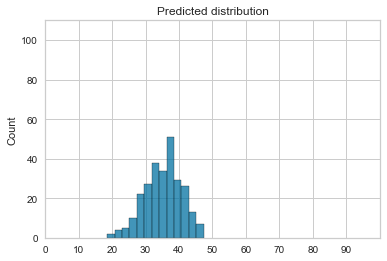

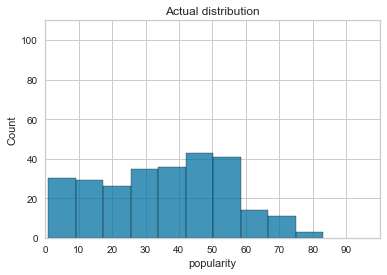

In [66]:
prediction_dist(X_test, y_test, lasso)

C:\Users\thoma\anaconda3\envs\ml_nvidia_gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


0.13149376762418707

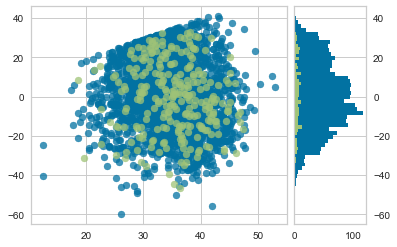

In [67]:
visualizer = ResidualsPlot(lasso)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test) 

__Binned Linear Regression with Lasso Summary__:

r2 train score:  0.15773226898788106
r2 test score:  0.14222262860954338

Goal MAE: 15.8455
Model MAE:  14.9

Goal MSE: 360
Model MSE: 330

Lasso Regression worked to mitigate the overfitting effect on the Binned Linear Regression model. Unfortunately it did not increase its score. And we can see on the distribution charts that it's biased towards the middle popularity values.

## Model 5: KNN regression
For the final model in task_a, we'll try the simplest one.
### Why this model:
Pros: 
* Simple to understand and explain. 
* Fast training.

Cons: 
* Doesn't work well with complex data as ours.

In [68]:
# Checking out model for intuitively chosen k-value
start = time.time()

knn_regr = KNeighborsRegressor(n_neighbors = 150)
knn_regr.fit(X_train, y_train)

task_a_results(knn_regr, X_train, y_train, X_test, y_test)


Fit time: 0.1615588665008545 seconds

MSE:  338.0796223880597
r2 train score:  0.061268202519983106
r2 test score:  0.061033452041623804
MAE:  15.412512437810944


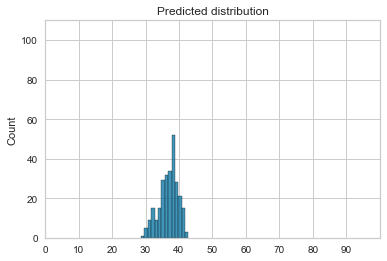

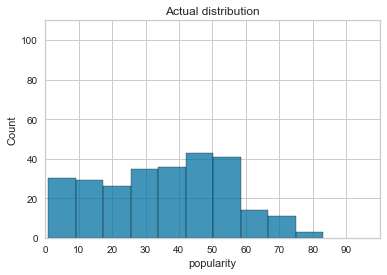

In [69]:
# Visualize prediction area for first model
prediction_dist(X_test, y_test, knn_regr)

__KNN Summary:__

Goal MAE: 15.8455
Model MAE: 
<br>
Goal MSE: 360
Model MSE: 


# Task B: Predicting features from album image data
## Introduction:
__Goal__: 
- Find theoretically suitable models for predicting features from the dataset in task A

__Hypothesis__:
* Image data correlates enough with popularity so that we can create decent models predicting popularity, danceability, speechiness and release_date better than the mean of the target data (or random)

__Risks/limitations__:
* Not enough data
*	Big contributors to the popularity scores are missing from the data set (like artist fame, cultural factors or Spotify algorithm bias).
*	Insufficient processing power (greater threat this time)
*	Theoretical knowledge limitations

We'll use the scaled data from task A to train these models. 
The processing power problem was mitigated using tensorflow-gpu library, allowing us to train models using a graphics card.

We're sceptical of the amount of much the album art will correlate with how much listeners play the albums, but we're hoping for something better than the mean!

### Scoring Methods:
__MSE__: Mean squared error
<br>
__MAE__: Mean absolute error

__Goal Score__: Autocalculated and included in the model_result function we created, run after each model.

R2 score is not included as a metric in core tensorflow. However, as we have scaled our data and can compare the scores with random/mean prediction scores, mean squared error and mean absolute error will be good enoug for eavaluating the models.

## Configs

In [70]:
# Function for ensuring correct path
def assert_path(path):
  if os.path.isdir(path):
    return path
  else:
    path = input("""Please specify image path. WARNING: Image directory should be inside another directory!
    Example path: /284_project_b/images/
    """)
    return assert_path(path)


# Define path to image files
IMAGES_PATH = assert_path(r'284_project_b/images')

print(f"Image path set to {IMAGES_PATH}")

Image path set to 284_project_b/images


## Functions

### Create X and y array with corresponding processed image data and target features from album_data

In [71]:
def add_to_plot(image, rows, columns, figure, axis, title, number):
  """
  Add image to plot
  """
  figure.add_subplot(rows, columns, number)
  # showing image
  plt.imshow(image)
  plt.axis(axis)
  plt.title(title)

def image_processing(image_path, visualizations = False):
  """
  Resize image to 256x256 to fit CNN model. Easy to expand if more processing is needed.
  :param: image_path: Directory path to image.
  :param: visualizations: Whether to visualize each step of the image processing.
  :return: Numpy array of picture.
  """
  # Load image
  image = Image.open(image_path)

  # For visualizing 
  # create figure
  fig = None
  if visualizations:
    fig = plt.figure(figsize=(10, 7))

  # Visualize original image
  if visualizations:
    add_to_plot(image, 2, 2, fig, "off", f"Original {image.size}", 1)

  #Resize the image to 256x256 pixels size
  image = image.resize((256, 256))
  
  # Visualize resized image
  if visualizations:
    add_to_plot(image, 2, 2, fig, "off", "Resized to 256x256", 2)
    
  # image = ImageOps.grayscale(image)

  # if visualizations:
  #   add_to_plot(image, 2, 2, fig, "off", "Greyscale", 3)
    
  return asarray(image)


def create_X_y(tab_data, images_path, target_feature):
  """
  Iterate tab_data to create X array containing images and y array containing 
  target features in same order.
  :param: tab_data: Tabular dataset containing feature target_feature and id 
          corresponding with image data name.
  :param: images_path: Path to image directory
  :param: target_feature: Target feature to cross-reference id with in tab_data.
  :return: tuple containing two numpy arrays, X and y features
  """
  X = []
  y = []

  # For loading bar
  iterations = 0
  for id in tab_data["id"]:
    iterations += 1

    # Loading bar, updated every whole number
    if str(iterations)[-1] == "0":
      progress_num = int((iterations/len(tab_data))*100)
      print(f"Progress: {progress_num}/100 [{'|'*progress_num}]", end='\r')

    image_path = f"{images_path}/{id}.png"
    
    # Process image and load as numpy array
    image = image_processing(image_path)

    target_datapoint = tab_data.loc[tab_data.id == id][target_feature]

    X.append(image)
    y.append(float(target_datapoint))

  return (asarray(X), asarray(y))

### Show model results

In [72]:
# Borrowed and modified from: https://medium.com/@mikhaillenko/instructions-for-transfer-learning-with-pre-trained-cnns-203ddaefc01
def show_results(history, X_test, y_test, y):
  """
  Graphs the models progression with its different metrics through training and validation.
  Finally shows test data score.
  :param: trained_model: Model History object
  :param: X_test: Test data corresponding to trained_model training data
  :param: y_test: Target data corresponding to trained_model target data
  :param: y: Whole target feature, for comparing with metrics with mean
  """
  # Defining dependent variables for plotting
  loss, metric, val_loss, val_metric = history.history.values()
    
  model = history.model

  # Defining independent variable for plotting
  epochs = range(len(metric))
  # Creating grid of subplots
  fit, axes = plt.subplots(1, 2, figsize=(12, 5))
  sns.axes_style('whitegrid')
  # Plotting accuracy
  sns.lineplot(x=epochs,
               y=metric,
               color='r',
               label='Training mae',
               ax=axes[0])
  sns.lineplot(x=epochs,
               y=val_metric,
               color = 'b',
               label='Validation mae',
               ax=axes[0])

  # Plotting loss
  sns.lineplot(x=epochs,
               y=loss,
               color='r',
               label='Training loss',
               ax=axes[1])
  sns.lineplot(x=epochs,
               y=val_loss,
               color = 'b',
               label='Validation loss',
               ax=axes[1])
  
  

  plt.tight_layout()
  plt.show()
  
  # Final score:
  score = model.evaluate(X_test, y_test)
  # Get metric name from history dictionary
  metric_name = list(history.history.keys())[1]
  # Extract loss and other metric
  loss, metric = score
  print(f"Final model scores: loss:{loss}, {metric_name}: {metric}")
  mean_mse_comparison = mean_mse(y)
  mean_mae_comparison = mean_mae(y)
  print(f"If our model were to guess the mean every time it would guess: mse: {mean_mse_comparison}, mae: {mean_mae_comparison}")

## Inspecting the data

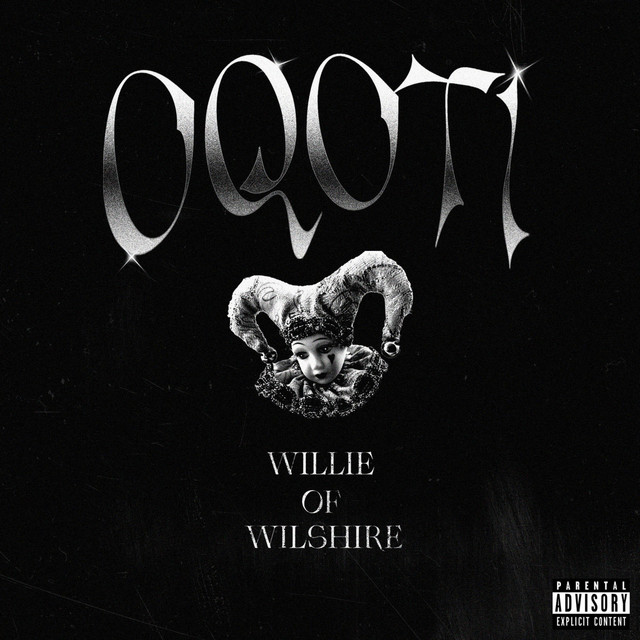

In [73]:
load_image = keras.preprocessing.image.load_img(f'{IMAGES_PATH}/146983.png')
load_image

## Data processing

Processing:

Resizing: We resize the image to 256x256 to fit it into the model.

Cropping: We will not do any cropping. Even though some older record images were in a larger format that allowed for a margin on the sides and displayed more imporant features in the middle, spotify album images are shown in a very small picture. Therefore, album designers need to use all of the picture to include important features. As our dataset is small we can afford to do that as well.

Grayscale: Like in with the cropping, we keep the RGB dimensions with the hypothesis that color usage affects peoples album choices.



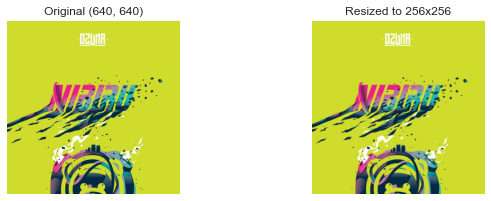

In [74]:
image = image_processing(f"{IMAGES_PATH}/1.png", visualizations = True)

In [75]:
len(df)

2672

## Image Data Visualizations

## Dimension reduction

We did an attempt at PCA, but ended up with more dimensions than when we simply resized the images. We'll keep it simple.

We also tried a clustering algorithm to see which pictures would go in the same category. They ended up being sorted by colors, so we removed the visualization as it was slow with lots of code and ran really slowly.

## CNN1: Predicting popularity

### Loading images and target data in memory as numpy arrays
Normally in image analysis through neural networks you have too many image data points for the computers memory. Therefore you create subdirectories with as labels and load images and labels to the model in batches. This is a very effective way of doing it with a few classes, but we struggled with using these functions for regression purposes, with 100 labels. We made a script for it, but struggled with data loss and other complications. To not waste more time on this, we load the images directly to numpy arrays instead.


In [76]:
# Create X and y array for popularity
X, y = create_X_y(df, IMAGES_PATH, "popularity")

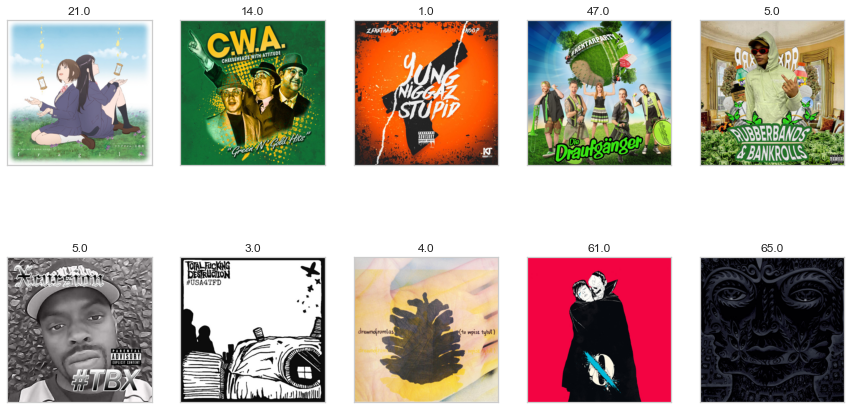

In [77]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(y, X, axes.ravel()):
    ax.imshow(image)
    ax.set_title(target)

 Creating feature (X) and target (y) array


In [78]:
print(f"Length of X: {len(X)}, length of y: {len(y)}.")

Length of X: 2672, length of y: 2672.


__Split between  training, testing and validation__
Small test and validation sets to preserve as much of the sparse data as possible for training.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)
print(f"Training set length: {len(X_train)}. Validation set length: {len(X_val)}. Test set length: {len(X_test)}")


Training set length: 2137. Validation set length: 268. Test set length: 267


We'll use VGG16 and create our own regression top.

In [80]:
popularity_model = VGG16(input_shape=(256,256,3),
                               weights='imagenet',
                               include_top=False)

Choice of loss parameters:
* Loss: As loss function we choose the Mean Squared Error. This is a popular and effective way of representing the models error
* Optimizer: AdaGrad, a version of gradient descent that adjusts learning rate automatically afer each batch. It is more computationally expensive but should work well with our small data set.
* Activation function: As we don't want negative numbers, we choose the ReLu function.
* Metrics / Evaluation: Mean Squared Error and Mean Absolute Error as discussed earlier.

In [81]:
# Freezing layers in convolutional model
popularity_model.trainable = False

# Regression block
x = layers.GlobalAveragePooling2D()(popularity_model.output)
x = layers.Dense(1, activation='relu')(x)

# Compiling the model
popularity_model = Model(popularity_model.input, x)
popularity_model.compile(loss='mse',
              optimizer = Adagrad(),
              metrics = ['mae'])

In [82]:
# Fitting model for our custom task
popularity_history = popularity_model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs=50,
                    verbose = 1)

Epoch 1/50
67/67 [==============================] - 14s 135ms/step - loss: 913.4904 - mae: 25.0196 - val_loss: 730.7486 - val_mae: 21.9419
Epoch 2/50
67/67 [==============================] - 6s 89ms/step - loss: 631.8137 - mae: 20.5721 - val_loss: 595.4846 - val_mae: 19.7263
Epoch 3/50
67/67 [==============================] - 6s 89ms/step - loss: 548.0128 - mae: 19.2144 - val_loss: 540.8615 - val_mae: 18.7095
Epoch 4/50
67/67 [==============================] - 6s 89ms/step - loss: 512.0128 - mae: 18.5995 - val_loss: 515.3734 - val_mae: 18.2629
Epoch 5/50
67/67 [==============================] - 6s 90ms/step - loss: 494.4493 - mae: 18.2922 - val_loss: 502.3629 - val_mae: 18.0281
Epoch 6/50
67/67 [==============================] - 6s 90ms/step - loss: 485.1851 - mae: 18.1133 - val_loss: 495.0184 - val_mae: 17.8936
Epoch 7/50
67/67 [==============================] - 6s 90ms/step - loss: 479.7080 - mae: 17.9918 - val_loss: 490.6227 - val_mae: 17.8156
Epoch 8/50
67/67 [=====================

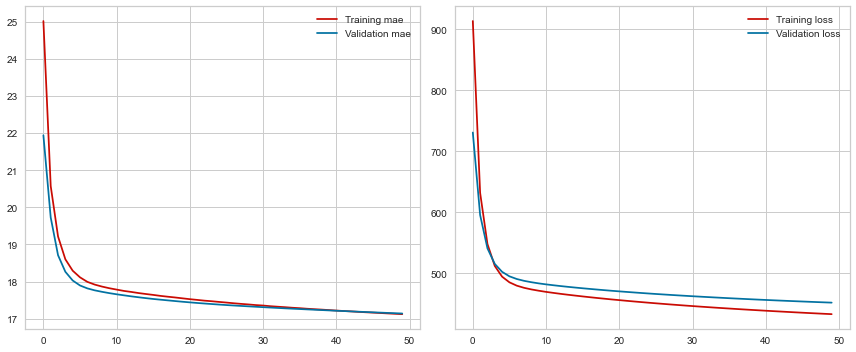

9/9 [==============================] - 2s 197ms/step - loss: 454.7274 - mae: 17.3408
Final model scores: loss:454.7274169921875, mae: 17.34076690673828
If our model were to guess the mean every time it would guess: mse: 361.88356058280146, mae: 15.862460053695004


In [83]:
# Borrowed and modified from: https://medium.com/@mikhaillenko/instructions-for-transfer-learning-with-pre-trained-cnns-203ddaefc01

show_results(popularity_history, X_test, y_test, y)

__CNN1 Summary__:
The model is quite well balanced, just very sligthly overfit. This can be seen in the graph, where the training loss is smaller than the validation loss. Unfortunately it predicts worse than the mean.

## CNN2: Predicting mean track danceability
Using same procedures as in CNN1, except one thing: danseability for an album is indicated by three of its tracks. While the limited track sample size is a bottleneck in itself, predicting each track's danceability from the album cover won't say much about the album as a whole. An Avicii album might have 10 songs with high danceability and 1 random slow song. Therefore we will attempt to predict the mean danceability of our sample tracks to represent album danceability.

In [84]:
# Merge danceability columns through mean
df["mean_t_dance"] = df[['t_dance0', 't_dance1', 't_dance2']].mean(axis=1)


In [85]:
# Create X and y array for release_date
X, y = create_X_y(df, IMAGES_PATH, "mean_t_dance")

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)
print(f"Training set length: {len(X_train)}. Validation set length: {len(X_val)}. Test set length: {len(X_test)}")

Training set length: 2137. Validation set length: 268. Test set length: 267


Changing activation function to sigmoid to reflect target range 0-1.

In [87]:
danceability_model = VGG16(input_shape=(256,256,3),
                               weights='imagenet',
                               include_top=False)

# Freezing layers in convolutional base
danceability_model.trainable = False

# Regression block
x = layers.GlobalAveragePooling2D()(danceability_model.output)
x = layers.Dense(1, activation='sigmoid')(x)

# Compiling the model
danceability_model = Model(danceability_model.input, x)
danceability_model.compile(loss='mse',
              optimizer = Adagrad(),
              metrics = ['mae'])

In [88]:
# Fitting model for our custom task
danceability_history = danceability_model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs=100,
                    verbose = 1)

Epoch 1/100
67/67 [==============================] - 7s 93ms/step - loss: 0.2027 - mae: 0.3973 - val_loss: 0.1768 - val_mae: 0.3660
Epoch 2/100
67/67 [==============================] - 6s 90ms/step - loss: 0.1677 - mae: 0.3632 - val_loss: 0.1666 - val_mae: 0.3582
Epoch 3/100
67/67 [==============================] - 6s 90ms/step - loss: 0.1613 - mae: 0.3567 - val_loss: 0.1632 - val_mae: 0.3579
Epoch 4/100
67/67 [==============================] - 6s 90ms/step - loss: 0.1584 - mae: 0.3542 - val_loss: 0.1622 - val_mae: 0.3559
Epoch 5/100
67/67 [==============================] - 6s 90ms/step - loss: 0.1562 - mae: 0.3504 - val_loss: 0.1606 - val_mae: 0.3541
Epoch 6/100
67/67 [==============================] - 6s 90ms/step - loss: 0.1540 - mae: 0.3476 - val_loss: 0.1604 - val_mae: 0.3521
Epoch 7/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1524 - mae: 0.3447 - val_loss: 0.1594 - val_mae: 0.3506
Epoch 8/100
67/67 [==============================] - 6s 91ms/step - loss: 0.

67/67 [==============================] - 6s 91ms/step - loss: 0.1251 - mae: 0.3034 - val_loss: 0.1435 - val_mae: 0.3311
Epoch 63/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1248 - mae: 0.3034 - val_loss: 0.1434 - val_mae: 0.3306
Epoch 64/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1247 - mae: 0.3027 - val_loss: 0.1432 - val_mae: 0.3304
Epoch 65/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1244 - mae: 0.3023 - val_loss: 0.1430 - val_mae: 0.3304
Epoch 66/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1242 - mae: 0.3021 - val_loss: 0.1428 - val_mae: 0.3301
Epoch 67/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1240 - mae: 0.3017 - val_loss: 0.1426 - val_mae: 0.3299
Epoch 68/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1238 - mae: 0.3016 - val_loss: 0.1425 - val_mae: 0.3295
Epoch 69/100
67/67 [==============================] - 6s 91ms/step - loss: 0.1236 

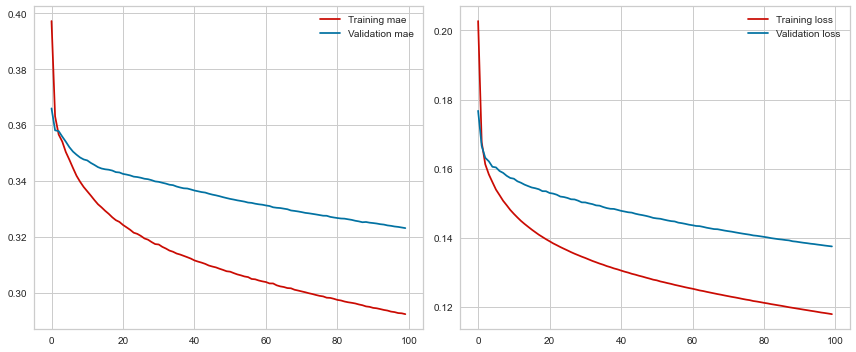

9/9 [==============================] - 1s 75ms/step - loss: 0.1428 - mae: 0.3315
Final model scores: loss:0.1427859663963318, mae: 0.3314976394176483
If our model were to guess the mean every time it would guess: mse: 0.02432966032934739, mae: 0.12464270960324861


In [89]:
show_results(danceability_history, X_test, y_test, y)

__CNN2 Summary__:
This model is very overfit. The validation loss is much higher than the training loss. Ways of alleviating this would be to integrate a regularization layer in the model, and train it for fewer epochs. This would limit the score potential however.

## CNN3: Predicting mean track speechiness

In [90]:
# Merge danceability columns through mean
df["mean_t_speech"] = df[['t_speech0', 't_speech1', 't_speech2']].mean(axis=1)

# Create X and y array for release_date
X, y = create_X_y(df, IMAGES_PATH, "mean_t_speech")



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)
print(f"Training set length: {len(X_train)}. Validation set length: {len(X_val)}. Test set length: {len(X_test)}")



speechiness_model = VGG16(input_shape=(256,256,3),
                               weights='imagenet',
                               include_top=False)

# Freezing layers in convolutional base
speechiness_model.trainable = False

# Regression block
x = layers.GlobalAveragePooling2D()(speechiness_model.output)
x = layers.Dense(1, activation='sigmoid')(x)

Training set length: 2137. Validation set length: 268. Test set length: 267||||||||||||||||||||||||||||||||||||||||||]


In [91]:
# Compiling the model
speechiness_model = Model(speechiness_model.input, x)
speechiness_model.compile(loss='mse',
              optimizer = Adagrad(),
              metrics = ['mae'])

# Fitting model for our custom task
speechiness_history = speechiness_model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs=50,
                    verbose = 1)


Epoch 1/50
67/67 [==============================] - 7s 92ms/step - loss: 0.0946 - mae: 0.1994 - val_loss: 0.0429 - val_mae: 0.1393
Epoch 2/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0457 - mae: 0.1409 - val_loss: 0.0380 - val_mae: 0.1317
Epoch 3/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0384 - mae: 0.1319 - val_loss: 0.0359 - val_mae: 0.1303
Epoch 4/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0355 - mae: 0.1281 - val_loss: 0.0345 - val_mae: 0.1295
Epoch 5/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0339 - mae: 0.1262 - val_loss: 0.0333 - val_mae: 0.1287
Epoch 6/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0328 - mae: 0.1248 - val_loss: 0.0324 - val_mae: 0.1281
Epoch 7/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0319 - mae: 0.1239 - val_loss: 0.0317 - val_mae: 0.1274
Epoch 8/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0313 - m

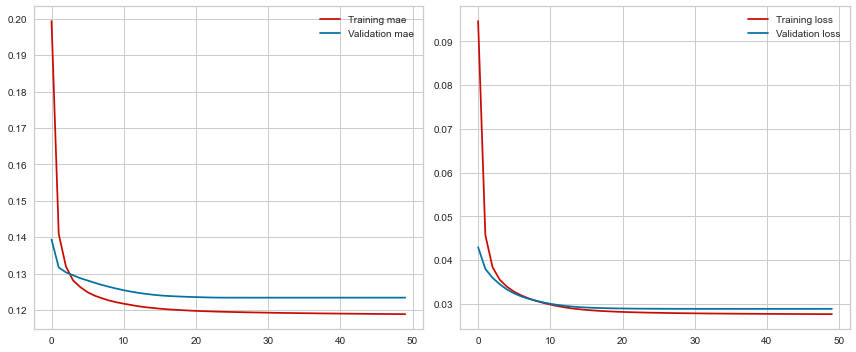

9/9 [==============================] - 1s 74ms/step - loss: 0.0253 - mae: 0.1181
Final model scores: loss:0.02527380920946598, mae: 0.11811912059783936
If our model were to guess the mean every time it would guess: mse: 0.013298389325834204, mae: 0.08572712285010817


In [92]:
show_results(speechiness_history, X_test, y_test, y)

__CNN3 Summary__:
This model did much worse than predicting the mean. However it did not overfit very much as trianing and validation loss vas quite close.

## CNN4: Predicting release_date



In [93]:
# Create X and y array for release_date
X, y = create_X_y(df, IMAGES_PATH, "release_date")

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)

In [95]:
print(f"Training set length: {len(X_train)}. Validation set length: {len(X_val)}. Test set length: {len(X_test)}")



rd_model = VGG16(input_shape=(256,256,3),
                               weights='imagenet',
                               include_top=False)

# Freezing layers in convolutional base
rd_model.trainable = False

# Regression block
x = layers.GlobalAveragePooling2D()(rd_model.output)
x = layers.Dense(1, activation='sigmoid')(x)

Training set length: 2137. Validation set length: 268. Test set length: 267


In [96]:
# Compiling the model
rd_model = Model(rd_model.input, x)
rd_model.compile(loss='mse',
              optimizer = Adagrad(),
              metrics = ['mae'])

# Fitting model for our custom task
rd_history = rd_model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs=50,
                    verbose = 1)

Epoch 1/50
67/67 [==============================] - 7s 93ms/step - loss: 0.1772 - mae: 0.2836 - val_loss: 0.1117 - val_mae: 0.2116
Epoch 2/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0726 - mae: 0.1645 - val_loss: 0.0822 - val_mae: 0.1741
Epoch 3/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0591 - mae: 0.1477 - val_loss: 0.0727 - val_mae: 0.1638
Epoch 4/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0540 - mae: 0.1418 - val_loss: 0.0684 - val_mae: 0.1578
Epoch 5/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0514 - mae: 0.1383 - val_loss: 0.0667 - val_mae: 0.1546
Epoch 6/50
67/67 [==============================] - 6s 90ms/step - loss: 0.0500 - mae: 0.1362 - val_loss: 0.0659 - val_mae: 0.1534
Epoch 7/50
67/67 [==============================] - 6s 91ms/step - loss: 0.0492 - mae: 0.1350 - val_loss: 0.0654 - val_mae: 0.1526
Epoch 8/50
67/67 [==============================] - 6s 91ms/step - loss: 0.0487 - m

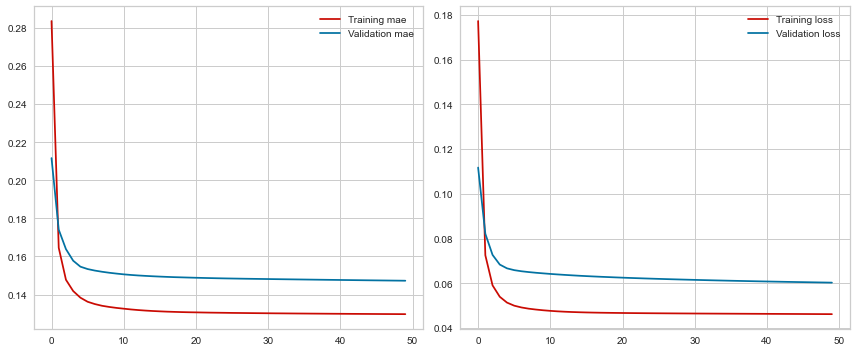

9/9 [==============================] - 1s 74ms/step - loss: 0.0496 - mae: 0.1394
Final model scores: loss:0.04957699030637741, mae: 0.13936986029148102
If our model were to guess the mean every time it would guess: mse: 0.029238789534620457, mae: 0.12559085343924697


In [97]:
show_results(rd_history, X_test, y_test, y)

__CNN4 Summary__:
The model manages to predict approximately a little bit worse than the mean. Another time we ran it with fewer epochs, it predicted almost exactly the mean, and the validation loss is higher than the training loss.

# Summary

__Predicting popularity:__
Predicting popularity with the data we have at hand proved a difficult task. We did not find the features to have any significant correlation with the target, and this made it hard for our models to predict much better than random. Our tree models also had severe problems with overfitting to the complex data. However, some of our models did actually do slighlty better than random. Our best models were:
* Random Forest: With RScore of 0.20675712806654112
 
* Gradient boosting: With RScore of 0.21946395570384158
Even though they were overfit, the test scores were higher than the other models.

__Predicting features from images:__
Using pre-trained neural networks and keeping the images in memory, we managed to train neural networks without using very much computational power or preprocessing. As we suspected, our neural networks did not perform better than random prediction. Image art can be affected by many things, such as cultural factors, and will not necessarily reflect any attributes or features of the music it contains.

To further increase our models scores we start by acquiring more training data. With more data and more research on the features and correlations we could have focused our predictions on smaller domains. Maybe there's a high correlation between album popularity and energy specifically in the 2010s? Such cases could be examined more thouroughly, and could give the models some more robust underlying trends to adapt to.
However, given our limited dataset amd experience within data science, we're happy to have achieved some results that are slightly better than random!